<center>
    <span style="font-size: 1.0em; color:black"><b>
        Last update: August 2021
    </b></span>
    <br><br>
    <span style="font-size: 2.5em; color:black"><b>
        FLOWPanel
    </b></span>
    <br>
    <span style="font-size: 0.95em;"><i>
        Theory, implementation, examples, and validation
    </i></span> 
</center>

In [1]:
using Revise

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/edoalvar/.julia/packages/Revise/1boD5/src/packagedef.jl:1369


In [2]:
import FLOWPanel
pnl = FLOWPanel
gt  = FLOWPanel.GeometricTools

using Statistics
using LinearAlgebra
using PyPlot
using3D()

# module_path = splitdir(@__FILE__)[1]  # Path to this module
data_path = pnl.def_data_path         # Data path
                                      # Airfoil data path
airfoil_path = joinpath(data_path, "airfoils");

# Table of Contents

<div id="toc"></div>

In [2]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
"""

# Geometric Engine &mdash; [`GeometricTools.jl`](https://github.com/byuflowlab/GeometricTools.jl)

The lifting-surface solver implemented in FLOWPanel requires a structured surface-grid that facilitates the declaration of edges along which to specify the Kutta condition. Hence, all paneled bodies are required to be structured grids. 

The package [`GeometricTools.jl`](https://github.com/byuflowlab/GeometricTools.jl) implements a variety of methods for the generation of grids and meshes, refinement, and space transformations, and is chosen as the geometric engine for FLOWPanel. Here below we show the low level manipulation of `GeometricTools.jl` for the sake of showing how to manually define complex geometries based on space transformations and localized refinement. The section *Body Definition* shows predefined methods for creating common geometries, *e.g.*, lofted surfaces, surfaces of revolution, etc.

## Generic Grid

The object `Grid` defines a structured cartesian $n$-dimensional grid and it is the base for all other types of grids. Here below is the object constructor and associated functions. For examples see [the documentation of GeometricTools](https://nbviewer.jupyter.org/github/byuflowlab/GeometricTools.jl/blob/master/docs/Documentation.ipynb).

In [3]:
? gt.Grid

`Grid(P_min, P_max, NDIVS)`

Generates an n-dimensional grid.

**Arguments**

  * `P_min::Array{Float64,1}`   : Minimum point of the domain.
  * `P_max::Array{Float64,1}`   : Maximum point of the domain.
  * `NDIVS::Array{Int64,1}`     : Number of divisions in each coordinate.

**Properties**

  * `dims::Int64`               : Number of dimensions.
  * `nnodes::Int64`             : Number of nodes in the grid.
  * `nodes::Array{Float64,2}`   : Matrix size (`nnodes`, `dims`) of node position.
  * `field` : Contains calculated fields formated as field[field*name] = Dict(                         "field*name" => field*name::String,                         "field*type" => "scalar" or "vector",                         "entry*type" => "node" or "cell",                         "field*data" => data                         )         where `data` is an array data[i] = [val1, val2, ...] containing         this field values (scalar or vector) at each node in the grid.

NOTE: All indexing is done linearly, meaning that `nodes` is indexed from 1 to       `nnodes`, and all data fields follow the same indexing.

NOTE2: `NDIVS` can either be an array of integers with NDIVS[i] indicating the       number of divisions in the i-th coordinate, or it can be an array of       sections (see `multidiscretize()` doc) with NDIVS[i] = [sec1, sec2, ...]       indicating the discretization into sections in the i-th coordinate.


In [4]:
? gt.get_node

`get_node(grid, i)`

Returns the position of the i-th node (1-indexed) in the grid

---

`get_node(grid, coor)`

Returns the position of the node of subscript coordinates `coor` (1-indexed)


In [5]:
? gt.get_cell

`get_cell(grid, i)`

Returns the nodes indices of i-th cell in the grid (1-indexed)

---

`get_cell(grid, coor)`

Returns the node indices of the cell with subscript coordinates `coor` (1-indexed). The format corresponds to VTK*HEXAHEDRON (=12) in 3D, VTK*QUAD (=9) in 2D, or VTK_LINE (=3) in 1D–-except that points are 1-indexed instead of 0-indexed.


<table style="width:100%">
  <tr>
    <td>
        <img src="img/vtk00.png" alt="Pic here" style="width: 200px;"/>
    </td>
    <td>
        <img src="img/vtk01.png" alt="Pic here" style="width: 150px;"/>
    </td>
    <td>
        <img src="img/vtk02.png" alt="Pic here" style="width: 200px;"/>
    </td>
  </tr>
</table>

In [6]:
? gt.add_field

`add_field(grid::Grid, field_name::String, field_type::String, field_data, entry_type::String)`

Adds a field of data associated to each node.

NOTE: each data entry must be a single value if `field_type==scalar`, or a       3-element array if `field_type==vector`.


In [7]:
? gt.calculate_field

`calculate_field(grid::Grid, f, field_name::String, field_type::String)`

Evaluates the function `f` at each nodes and stores the values as a new field.

NOTE: f must return a single value if `field_type==scalar`, or a 3-element array       if `field_type==vector`.


In [8]:
? gt.get_fieldval

`get_fieldval(grid, field_name, coor)`

Returns the value of node of coordinates `coor` (1-indexed) in the field 'field_name'.

---

`get_fieldval(grid, field_name, i)`

Returns the value of i-th node (1-indexed) in the field 'field_name'.


## Space Transformation

In [9]:
? gt.transform!

`transform!(grid::Grid, f)`

Applies the space transformation given by function `f` to the grid, where the position of every node is given to the function `f`.


In [10]:
? gt.lintransform!

`lintransform!(grid::Grid, M::Array{Float64,2}, T::Array{Float64,1})`

Rotates and translates the grid by the rotation matrix `M` and translation vector `T` (linear transformation).


Nonlinear [orthogonal space transformations](https://en.wikipedia.org/wiki/Orthogonal_coordinates) are implemented as `cylindrical3D(X)`, `cylindrical2D(X)`, `spherical3D(X)`, `parabolic3D(X)`, `paraboloidal3D(X)`, `elliptic3D(X; a=1)`, `prolate3D(X; a=1)`, `oblate3D(X; a=1)`, `bipolar3D(X; a=1)`, `toroidal3D(X; a=1)`, and `conical3D(X; b=2, c=1)`. 

For linear transformations, `rotation_matrix(yaw::Real, pitch::Real, roll::Real)` returns the rotation matrix of such angles, and `axis_rotation(r::Array{Float64, 1}, angle_deg::Float64)` returns the transformation matrix of rotation around an arbitrary axis of unit vector `r`.

The user can also define an arbitrary space transformation. The airfoil example in the Looped Grid section shows the example of transforming a quasi-one-dimensional line into an two-dimensional airfoil contour.

## Example: Circular Grid

Here we generate a two-dimensional circular grid by first defining the boundaries of the circular section $r_\text{min}, r_\text{max}, \theta_\text{min}, \theta_\text{max}$ as a cartesian grid of $P_\text{min}=(r_\text{min}, \theta_\text{min})$ and $P_\text{max}=(r_\text{max}, \theta_\text{max})$ and then applying a cylindrical transformation on the grid. The cylindrical transformations take the current coordinates of $x,y$ of the grid as $r,\theta$ for the new grid. In this case, $r_\text{min}=R/4$, $r_\text{max}=R$, $\theta_\text{min}=0^\circ$, $\theta_\text{max}=270^\circ$.

<img src="img/circ01.png" alt="Pic here" style="width: 600px;"/>

In [11]:
file_name = "temp_circgrid00"
paraview = true

R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 270*pi/180]   # Upper boundaries r, theta

NDIVS = [15, 60]          # 15 radius divisions, 60 angle divisions

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

# Visualization
if paraview
    # Outputs a vtk file
    gt.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end
nothing

Notice that `NDIVS` can still be used to defined sections of refinement:

<img src="img/circ02.png" alt="Pic here" style="width: 600px;"/>

In [12]:
file_name = "temp_circgrid01"
paraview = true

NDIVS = [   # r sections
            [(1.0, 15, 5.0, true)],
            # theta sections
            [(1/3, 15, 1/3, false),
             (1/3, 15, 3.0, true),
             (1/3, 15, 3.0, false)]
        ]

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

# Visualization
if paraview
    # Outputs a vtk file
    gt.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end
nothing

## Looped Grid

For some application it is convenient to be able to define a grid that loops on itself making the last cell in such dimension close back with the first cell. The `Grid` object accepts an optional argument indicating the dimension that loops on itself as follows:

`Grid(P_min, P_max, NDIVS, loop_dim)`

where `loop_dim` is an integer indicating the dimension to loop.


Here below is an example of a cylindrical grid $(r, \theta)$ where the nodes at $\theta=0^\circ$ and $\theta=360^\circ$ end up overlapping (notice nodes 1, 2, and 3 overlapping with 16, 17, and 18).

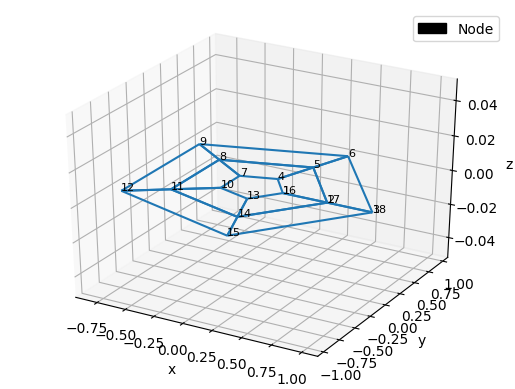

In [13]:
R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 360*pi/180]   # Upper boundaries r, theta

NDIVS = [2, 5]          # 15 radius divisions, 60 angle divisions

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

gt.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

By giving it the argument `loop_dim=2`, we get the $\theta$-coordinate loop on itself, getting rid of the node overlap by merging them:

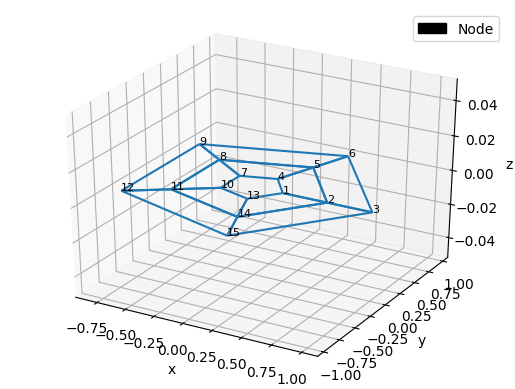

In [14]:
loop_dim = 2              # Loop the theta dimension

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

gt.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

## Example: Airfoil Contour

Here we use a space transformation and a looped grid to generate a two-dimensional airfoil section. The airfoil section is generated through the following procedure:

1. Read a collection of points from a CSV file describing an airfoil contour ("Original Airfoil Geometry").
2. Split the contour into upper and lower surfaces.
3. Spline through the points generating two analytic curve parameterized from inputs 0 to 1.
4. Generate a 1D line that represents a structured grid ("Original Grid").
5. Apply a space transformation to the 1D line to curve it in the shape of the airfoil contours ("Transformed Grid").

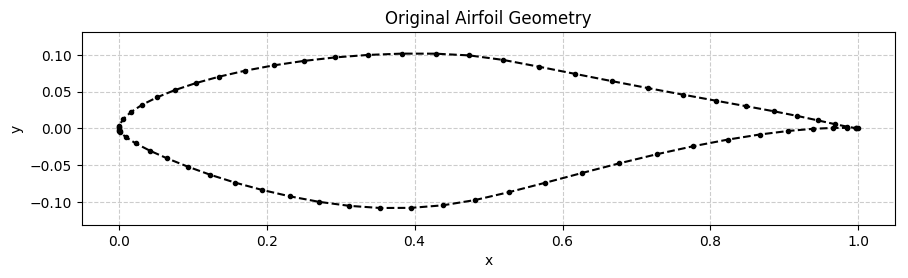

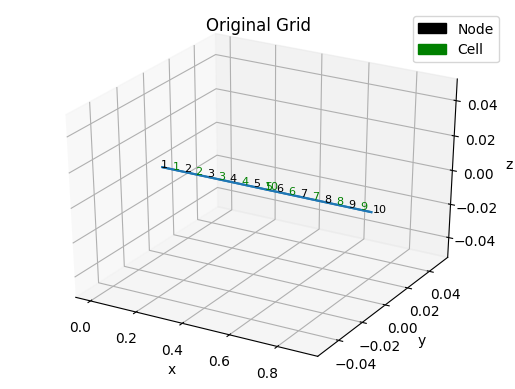

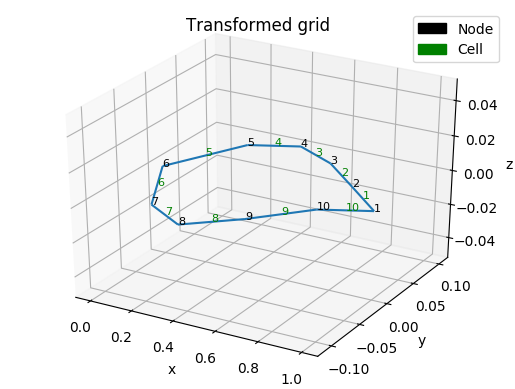

In [15]:

# ----------------- READS AND PARAMETERIZES AIRFOIL ---------------------------
# Read airfoil contour
x,y = gt.readcontour(joinpath(airfoil_path, "S809.txt"); header_len=2)
gt.plot_airfoil(x,y; style="--.k", title_str="Original Airfoil Geometry")

# Separate upper and lower surfaces to make the contour injective in x
upper, lower = gt.splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = gt.parameterize(upper[1], upper[2], zeros(size(upper[1])); inj_var=1, s=1e-6)
fun_lower = gt.parameterize(lower[1], lower[2], zeros(size(lower[1])); inj_var=1, s=1e-6)



# ----------------- CREATES GRID OF AIRFOIL CONTOUR ---------------------------
# Creates the grid as a quasi-one-dimensional line
#   `X[1]` is the arc-length around the airfoil contour (between 0 and 1),
#   `X[2]` is a dummy value.

P_min = [0, 0]             # Lower boundaries arclength, dummy
P_max = [1, 0]             # Upper boundaries arclength, dummy
NDIVS = [10, 0]            # 100 arclength divisions, 0 dummys
loop_dim = 1               # Loop the arclength dimension

grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

gt.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, fig_name="org", title_str="Original Grid")


# Creates a space transformation function
function my_space_transform(X)
    if X[1]<0.5
        return fun_upper(1-2*X[1])[1:2]
    else
        return fun_lower(2*(X[1]-0.5))[1:2]
    end
end

# Transforms the quasi-one-dimensional line into the two-dimensional
# airfoil contour
gt.transform!(grid, my_space_transform)

gt.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, title_str="Transformed grid");


## Surface Grid and "Quasi-Dimensions"

A three-dimensional surface grid can be generated by defining a three-dimensional grid where one of its dimensions has zero divisions, and then transforming the space into the surface geometry. A dimension with zero divisions is recognized as a "quasi-dimension", which is a place holder for space transformations without actually extending the dimensions of the grid. For instance, a three-dimensional grid with one quasi-dimension doesn't define its cells as VTK_HEXAHEDRONs as a regular three-dimensional grid would, but **its cells are defined as VTK_QUADs**. Also, quasi-dimensions are not considered as a coordinate direction, meaning that a node/cell in a three-dimensional grid with one quasi-dimension is not indexed by three coordinates $(i,j,k)$, but with **only two coordinates $(i,j)$**.

The following lines exemplify the process of defining the quasi-dimensional grid, and applying the space transformation:

```julia
# Creates quasi-three-dimensional grid
P_min = [0, -1, 0]            # Lower boundaries arclength, span, dummy
P_max = [1, 1, 0 ]            # Upper boundaries arclength, span, dummy
NDIVS = [20, 10, 0]           # 20 arclength cells, 10 span cells, 0 dummy
grid = gt.Grid(P_min, P_max, NDIVS)


# Creates a space transformation function
function my_space_transform(X)
    new_X = # Write a new definition of each node here
    return new_X
end

# Applies the space transformation
gt.transform!(grid, my_space_transform)
```

## Example: Paneled Wing

Here we use a space transformation on a 2D looped grid with 3D quasi-dimensions to generate the three-dimensional surface of an airplane wing.

<img src="img/wing04.png" alt="Pic here" style="width: 800px;"/>
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing04.gif" alt="Vid here" style="width: 800px;"/>

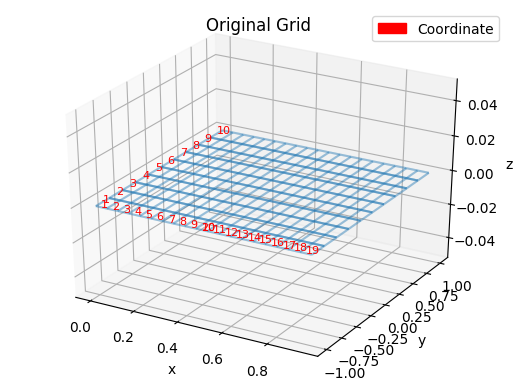

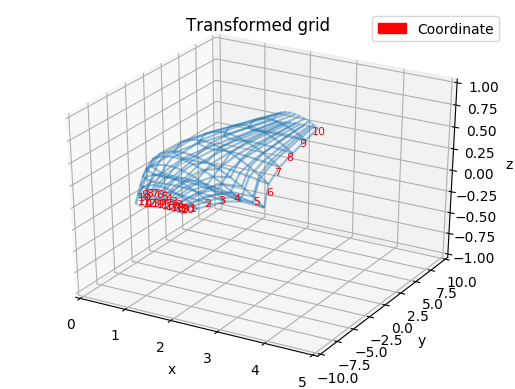

In [19]:
file_name = "temp_paneledwing00"
paraview = true

# ----------------- READS AND PARAMETERIZES AIRFOILS --------------------------
semispan = 10            # (m) semi-span length

chords = [(0, 2.5),      # (semi-span position, chord length (m))
          (0.25, 2.0),
          (1, 1.0)]

x_pos = [(0, 0),         # (semi-span position, leading edge x-position (m))
         (0.25, semispan/40 ),
         (1, semispan/8 )]

z_pos = [(0, 0),         # (semi-span position, leading edge z-position (m))
         (0.25, semispan/100 ),
         (1, semispan/50 )]

twist = [(0, 5),         # (semi-span position, twist (deg))
         (1, 0)]

airfoils = [(0, "naca6412.dat"), # (semi-span position, airfoil geometry)
            (1, "naca6412.dat")]

airfoil_funs = []

for (pos, airfoil_file) in airfoils
    # Reads the original airfoil geometry from airfoiltools.com
    org_x, org_y = gt.readcontour(joinpath(airfoil_path, airfoil_file); header_len=1)

    # Separate upper and lower sides to make the contour injective in x
    upper, lower = gt.splitcontour(org_x, org_y)

    # Parameterize both sides independently
    fun_upper = gt.parameterize(upper[1], upper[2], zeros(size(upper[1])); inj_var=1)
    fun_lower = gt.parameterize(lower[1], lower[2], zeros(size(lower[1])); inj_var=1)
    
    push!(airfoil_funs, [pos, (fun_upper, fun_lower)])
end


# ----------------- CREATES PANEL GRID ----------------------------------------
P_min = [0, -1, 0]            # Lower boundaries arclength, span, dummy
P_max = [1, 1, 0 ]            # Upper boundaries arclength, span, dummy
NDIVS = [20, 10, 0]           # 50 arclength cells, 10 span cells, 0 dummy
loop_dim = 1                  # Loop the arclength dimension

grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, fig_name="org", title_str="Original Grid", 
                alpha=0.25)


# Auxiliary function for weighting values across span
function calc_vals(span, array)
    
    # Finds bounding airfoil position
    val_in, val_out = nothing, array[1]
    for val in array[2:end]
        val_in = val_out
        val_out = val
        if val[1]>=abs(span); break; end
    end 
    pos_in = val_in[1]
    val_in = val_in[2]
    pos_out = val_out[1]
    val_out = val_out[2]
    
    weight = (abs(span)-pos_in)/(pos_out-pos_in)
            
    return weight, val_in, val_out
end

# Creates a space transformation function
function my_space_transform(X)
    span = X[2]
    
    # Calculates chord
    weight, chord_in, chord_out = calc_vals(span, chords)
    chord = weight*chord_out+(1-weight)*chord_in
    
    # Calculates airfoil geometry
    weight, rfl_in, rfl_out = calc_vals(span, airfoil_funs)
    fun_upper_in, fun_lower_in = rfl_in
    fun_upper_out, fun_lower_out = rfl_out
    
    # Arc-length on upper or lower side of airfoil
    if X[1]<0.5
        s = 1 - 2 * X[1]
        fun_in = fun_upper_in
        fun_out = fun_upper_out
    else
        s = 2 * (X[1] - 0.5)
        fun_in = fun_lower_in
        fun_out = fun_lower_out
    end
    
    # Point over airfoil contour
    point =  weight * fun_out(s) + (1 - weight) * fun_in(s)
    point = chord * point
    
    # Twist
    weight, twist_in, twist_out = calc_vals(span, twist)
    this_twist = weight * twist_out + (1 - weight) * twist_in
    
    # Applies twist to the airfoil point
    point = gt.rotation_matrix(-this_twist, 0, 0) * point
    
    # Leading edge x-position
    weight, x_in, x_out = calc_vals(span, x_pos)
    le_x = weight * x_out + (1 - weight) * x_in
    
    # Leading edge z-position
    weight, z_in, z_out = calc_vals(span, z_pos)
    le_z = weight * z_out + (1 - weight) * z_in
    
    # Span position
    y = X[2] * semispan
    
    return [point[1] + le_x, y, point[2] + le_z]
end

# Transforms the quasi-two dimensional grid into the wing surface
gt.transform!(grid, my_space_transform)


lims = [-semispan, semispan]
gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, title_str="Transformed grid", alpha=0.25,
                xlims=lims / 2 .* [0,1], ylims=lims, zlims=lims/10);

# Adds some dummy example fields
gt.add_field(grid, "node_index", "scalar", [i for i in 1:grid.nnodes], "node")
gt.add_field(grid, "cell_index", "scalar", [i for i in 1:grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    gt.save(grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end
nothing

By construction, the wing we have defined has nonplanar quadrilateral panel. Since some applications require planar panels, I have defined a special type of grid that receives a three-dimensional surface `Grid` object, and splits all nonplanar quadrilateral panels into planar triangular panels of the `VTK_TRIANGLE` type.

<img src="img/vtk_triangle.png" alt="Pic here" style="width: 200px;"/>

This is implemented in the `GridTriangleSurface` type:

In [20]:
? gt.GridTriangleSurface

`GridTriangleSurface(orggrid, dimsplit)`

Receives a 3D surface grid (like the one in `Paneled Wing Example` in the documentation), which by construction is made of nonplanar quadrilateral panels, and creates a surface grid of planar triangular panels by splitting every original quadrilateral panel into triangles.

**Arguments**

  * `orggrid`         : Original quadrilateral surface grid.
  * `dimsplit`        : Dimension along which to split the quadrilaterals.


In [21]:
file_name = "temp_paneledwing01"

# Splits the quadrialateral panels into triangles
dimsplit = 1              # Dimension along which to split
triang_grid = gt.GridTriangleSurface(grid, dimsplit)

# Adds some dummy example fields
gt.add_field(triang_grid, "node_index", "scalar", 
                    [i for i in 1:triang_grid.nnodes], "node")
gt.add_field(triang_grid, "cell_index", "scalar", 
                    [i for i in 1:triang_grid.ncells], "cell")
gt.add_field(triang_grid, "normal", "vector", 
                    [gt.get_normal(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")
gt.add_field(triang_grid, "tangent", "vector", 
                    [gt.get_tangent(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    gt.save(triang_grid, file_name)

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end
nothing

<img src="img/wing05.png" alt="Pic here" style="width: 800px;"/>

# Body Definition

In this section we describe and exemplify the different approaches for generating meshed (paneled) surfaces.

## `AbstractBody`

`AbstractBody` defines the abstract type on which all Body implementations extend. It is defined as follows:

In [3]:
? pnl.AbstractBody

Implementations of AbstractBody are expected to have the following fields.

  * `grid::gt.GridTriangleSurface`     : Paneled geometry
  * `nnodes::Int64`                     : Number of nodes
  * `ncells::Int64`                     : Number of cells
  * `fields::Array{String, 1}`          : Available fields (solutions)
  * `Oaxis::Array{T,2} where {T<:Real}` : Coordinate system of original grid
  * `O::Array{T,1} where {T<:Real}`     : Position of CS of original grid

and the following functions

```julia

# Solve for distributions of potential flow

function solve(self::BodyType, Vinfs::Array{Array{T,1},1}, args... ) where {T<:Real}     .     .     .   end

# Returns the velocity induced by the body on the targets `targets`. It adds

# the velocity at the i-th target to out[i].

function _Vind(self::BodyTypes, targets::Array{Array{T,1},1}, out::Array{Array{T,1},1}, args...; optargs...) where{T<:Real}     .     .     .   end   ```


The Union `BodyTypes` declares all implementations of `AbstractBody`:

In [6]:
pnl.BodyTypes

Union{FLOWPanel.NonLiftingBody, FLOWPanel.NonLiftingBodyDoublet, FLOWPanel.NonLiftingBodyVRing, FLOWPanel.RigidWakeBody}

All implementations of `AbstractBody` share the following functions:

In [7]:
? pnl.save

`save(body::BodyTypes, filename::String; opt_args...)`

Outputs a vtk file of this body. See GeometricTools.save(grid, ...) for a description of optional arguments `opt_args...`.


In [8]:
? pnl.get_controlpoint

`get_controlpoint(body::BodyTypes, i::Int64 or coor::Array{Int64,1})`

Returns the control point on the i-th panel.


In [9]:
? pnl.get_unitvectors

`get_unitvectors(body::BodyTypes, i::Int64 or coor::Array{Int64,1})`

Returns the unit vectors t,n,o of the i-th panel, with t the tanget vector, n normal, and o oblique.


In [10]:
? pnl.get_normal

`get_normal(body::BodyTypes, i::Int64 or coor::Array{Int64,1})`

Returns the normal vector the i-th panel.


In [11]:
? pnl.rotate

`rotate(body::BodyTypes, roll::Real, pitch::Real, yaw::Real; translation::Array{T, 1}=zeros(3), reset_fields::Bool=true ) where{T<:Real}`

Rotates and translates the body by the given axial angles.

NOTE: Naming follows aircraft convention, with

  * roll:   rotation about x-axis.
  * pitch:  rotation about y-axis.
  * yaw:    rotation about z-axis.


It is recommended that wings follow conventional aerodynamic coordinates, building the wing from left tip ($-y$) to right tip ($+y$), leading edge pointing in the direction of $-x$ and trailing edge in the direction of $+x$, and top side of the airfoil in the direction of $+z$. However, the user is free to define wings in any arbitrary convention since the solvers are indifferent to orientation. The solvers are indifferent to whether normals point inside or outside the geometry, but for consistency, it is good practice to define the geometry such as to have the normals pointing outside. This is done by building every airfoil **starting at the trailing edge first going around the bottom side towards the leading edge, and going back to the trailing edge around the top side**. The following figure shows the node indexing (green) and cell indexing (pink) of the left tip in a wing defined as explained above:

<img src="img/paneledwing00.png" alt="Pic here" style="width: 800px;"/>

## `NonLiftingBody`

In [12]:
? pnl.NonLiftingBody

`NonLiftingBody(grid::gt.GridTriangleSurface)`

Non-lifting paneled body that is solved using a constant source distribution. `grid` is the grid surface (paneled geometry).

**Properties**

  * `nnodes::Int64`                     : Number of nodes
  * `ncells::Int64`                     : Number of cells
  * `fields::Array{String, 1}`          : Available fields (solutions)
  * `Oaxis::Array{T,2} where {T<:Real}` : Coordinate system of original grid
  * `O::Array{T,1} where {T<:Real}`     : Position of CS of original grid


This type can be constructed by manually defining the grid using the gridding methods explained under the section "Geometric Engine", or using one of the following methods:

In [14]:
? pnl.generate_loft_nonliftbody

`generate_loft_nonliftbody(args...; optargs...)` Generates a lofted non-lifting body. See documentation of `GeometricTools.generate_loft` for a description of the arguments of this function.


In [15]:
? pnl.generate_revolution_nonliftbody

`generate_revolution_nonliftbody(args...; optargs...)` Generates a non-lifting body of a body of revolution. See documentation of `GeometricTools.surface_revolution` for a description of the arguments of this function.


## Lofting Method

All types detailed above implement some type of wrapper of the following lofting method in `GeometricTools`:

In [16]:
? pnl.gt.generate_loft

`generate_loft(crosssections, bscale, b_pos, chords, twists, LE_x, LE_z)`

Generates a lofted surface geometry. The name of the arguments are taken from   its initial application to the lofting of an aircraft wing, so bear with it.

**Arguments**

  * `bscale::Float64`         : Semi-span scale. It will scale the entire                             geometry by this factor.
  * `b_pos::Array{Float64, 1}`: Normalized span positions y/bscale of the                             following distributions.
  * `chords::Array{Float64,1}`: Chord c/bscale distribution.
  * `twists::Array{Float64,1}`: Twist (deg) distribution.
  * `LE_x::Array{Float64,1}`  : x-position (chordwise) x/bscale of leading edge                             distribution.
  * `LE_z::Array{Float64,1}`  : z-position (dihedral-wise) z/bscale of leading                             edge distribution.
  * `crosssections::Array{Tuple{T,Array{T,2}}, 1}`    : cross sections along the                             span in the form [(y/bscale, crosssection)],                             where `crosssection` is a matrix that contains                             all points of the airfoil contour indexed by                             row. In order to define the resulting normals                             pointing out of the geometry, the points in                             `crosssection` must start from the trailing                             edge, go around the top side towards the leading                             edge, and back to the trailing edge around the                             bottom side. ALL CROSS SECTIONS MUST HAVE THE                             SAME NUMBER OF POINTS.

**Optional Arguments**

  * `tilt_z::Array{Float64,1}`: Tilting (deg) about the z-axis of every span                             cross section. This is also a distribution.
  * `symmetric::Bool`         : Whether to consider the `crosssections` to be                             symmetric about the semi-span. If true, only                             positive y/bscale are neeeded.

NOTE: The resulting geometry will be a structured surface mesh with the first   index going in chordwise direction starting from the TE around the bottom   surface and around back to the TE. The second index is the in the spanwise   direction starting at left end (lowest position along y axis) to right end.

---

`generate_loft(crosssections, bscale, b_low, b_up, b_NDIVS, chords, twists, LE_x, LE_z; optargs...)`

Generates a lofted surface geometry. The name of the arguments are taken from   its initial application to the lofting of an aircraft wing, so bear with it.

**Arguments**

  * `bscale::Float64`         : Semi-span scale. It will scale the entire                             geometry by this factor. All y/bscale values in                             the following arguments must go from 0 to 1.
  * `b_low::Float64`          : Scaled lower bound of the span.
  * `b_up::Float64`           : Scaled upper bound of the span. To generate                             a symmetric wing, give it b*low=-1, b*up=1 and .                             symmetric=true; for a semi-span, give it                             b*low=0, b*up=1. If generating a prop blade,                             give it b*low=Rhub/Rtip, b*up=1.
  * `b_NDIVS`                 : Number of divisions (cells) along span. This                             if either an Int or an array of sections in the                             format of `multidiscretize()`.
  * `chords::Array{Float64,2}`: Chord distribution along the span in the form                             [y/bscale c/bscale].
  * `twists::Array{Float64,2}`: Twist distribution along the span in the form                             [y/bscale deg].
  * `LE_x::Array{Float64,2}`  : x-position (chordwise) of leading edge along the                             span in the form [y/bscale x/bscale].
  * `LE_z::Array{Float64,2}`  : z-position (dihedral-wise) of leading edge along                             the span in the form [y/bscale z/bscale].
  * `crosssections::Array{Tuple{T,Array{T,2}}, 1}`    : cross sections along the                             span in the form [(y/bscale, crosssection)],                             where `crosssection` is a matrix that contains                             all points of the airfoil contour indexed by                             row. In order to define the resulting normals                             pointing out of the geometry, the points in                             `crosssection` must start from the trailing                             edge, go around the top side towards the leading                             edge, and back to the trailing edge around the                             bottom side. ALL CROSS SECTIONS MUST HAVE THE                             SAME NUMBER OF POINTS.

**Optional Arguments**

  * `tilt_z::Array{Float64,2}`: Tilting about the z-axis of every span cross                             section in the form [(y/bscale, deg)].
  * `spl_k`, `spl_bc`, `spl_s`: Spline parameters with k the degree of the                             spline, bc the boundary condition, and s the                             smoothing or error of the spline.

NOTE: The resulting geometry will be a structured surface mesh with the first   index going in chordwise direction starting from the TE around the bottom   surface and around back to the TE. The second index is the in the spanwise   direction starting at left end (lowest position along y axis) to right end.

---

`generate_loft(crosssections, upper_rfl_NDIVS, lower_rfl_NDIVS, args...; rflspl_k::Int64=5, rflspl_s::Real=0.001, verify_rflspline::Bool=true, rfloptargs=[], optargs...)`

This function also rediscretizes the cross sections as indicated by   `upper_rfl_NDIVS`, and `lower_rfl_NDIVS` (upper and lower surface sections,   respectively). Hence, the original cross sections need not to have the same   number of points.

---

`generate_loft(crosssections::Array{Tuple{T,String}, 1},                         data_path::String, args...; header_len::Int64=1,                         delim::String=" ", optargs...) where{T<:Real}`

Loft a geometry where the cross sections are read from the files indicated by `crosssections` found in `data_path`.


### Example &ndash; Wing, uniform mesh

Here is a wing with a 5-th order spline. Since I'm giving it data points to spline that are quite sparse along the span, the splined values end up curving the chord distribution (see plots below).
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing00.gif" alt="Vid here" style="width: 900px;"/>

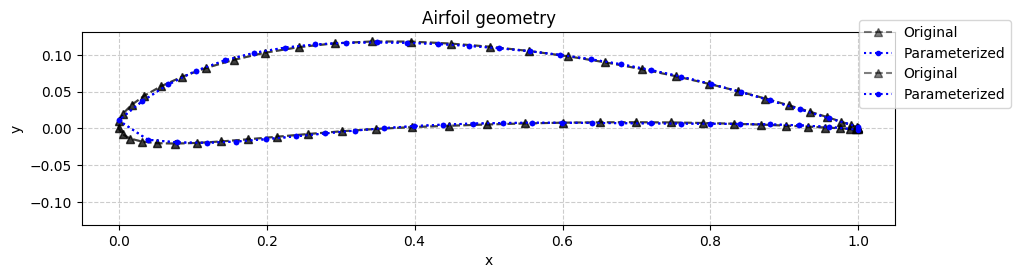

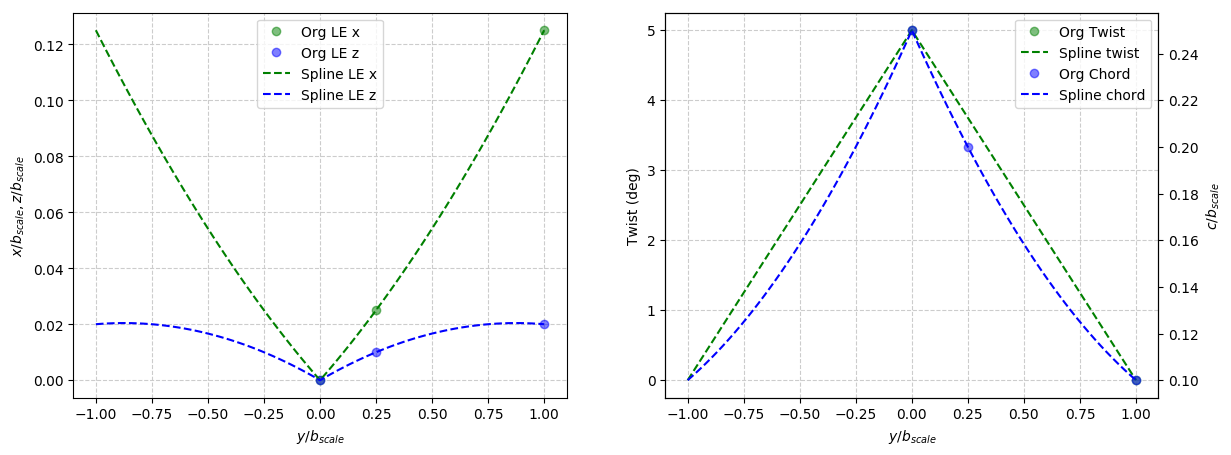

In [17]:
file_name = "paneledwing01"     # Output file name
save_path = "./"                # Save path

# ----------------- GEOMETRY DESCRIPTION -------------------------------------------
semispan = 10                       # (m) semi-span length

chords = [0.00 0.25;                # (semi-span position, chord c/semib)
          0.25 0.20;
          1.00 0.10]

twists = [0.0 5;                    # (semi-span position, twist (deg))
          1.0 0]

x_pos = [0.00 0;                    # (semi-span position, LE x-position x/semib)
         0.25 1/40;
         1.00 1/8;]

z_pos = [0.00 0;                    # (semi-span position, LE x-position x/semib)
         0.25 1/100;
         1.00 1/50]


airfoil_files = [(0.0, "naca6412.dat"), # (semi-span position, airfoil file)
                 (1.0, "naca6412.dat")]


# ----------------- MESHING PARAMETERS ---------------------------------------------
urfl_NDIVS = 25                     # Cells on upper side of airfoils
lrfl_NDIVS = 25                     # Cells on lower side of airfoils
b_NDIVS = 76                        # Span cells


# ----------------- LOFTING PARAMETERS ---------------------------------------------
b_low = -1.0                        # Lower bound of span lofting 
b_up = 1.0                          # Upper bound of span lofting
symmetric = true                    # Lofting symmetric about b=0
spl_k = 5                           # Spline order of distributions along span
spl_s = 0.001                       # Spline smoothing of distribution along span
verify_spline = true                # Plots the splined distributions

# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

In order to avoid the curving, we reduce the splining degree to only first order&mdash;which becomes a linear interpolation&mdash;however, the smoothing makes everything just a simple line from root to tip:
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing01.gif" alt="Vid here" style="width: 900px;"/>

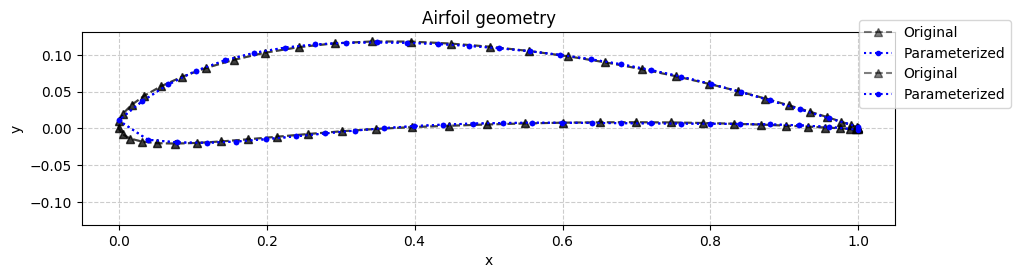

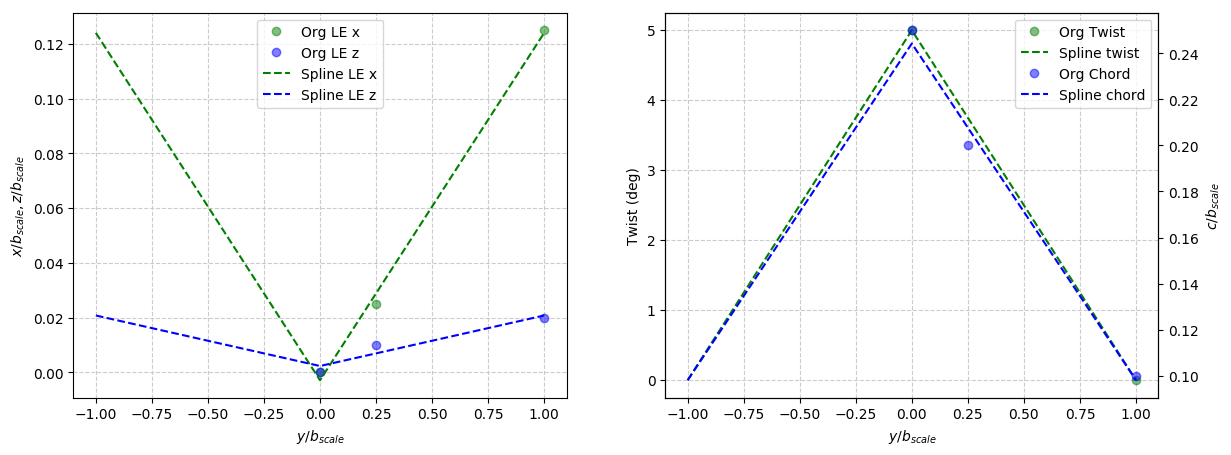

In [18]:
spl_k = 1                           # Spline order of distributions along span

# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

Decreasing the smoothing forces the spline to intersect every data point, finally obtaining the desired geometry:
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing02.gif" alt="Vid here" style="width: 900px;"/>

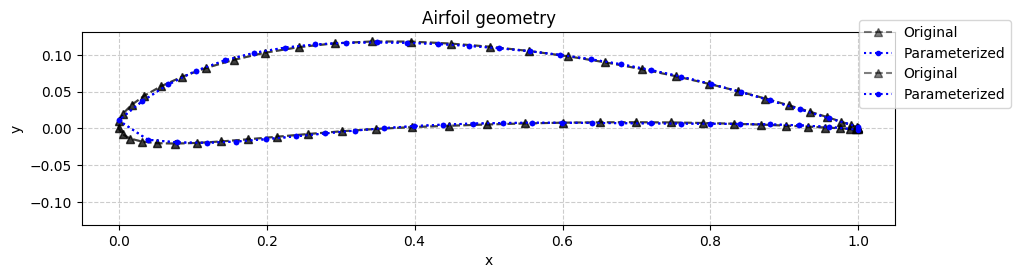

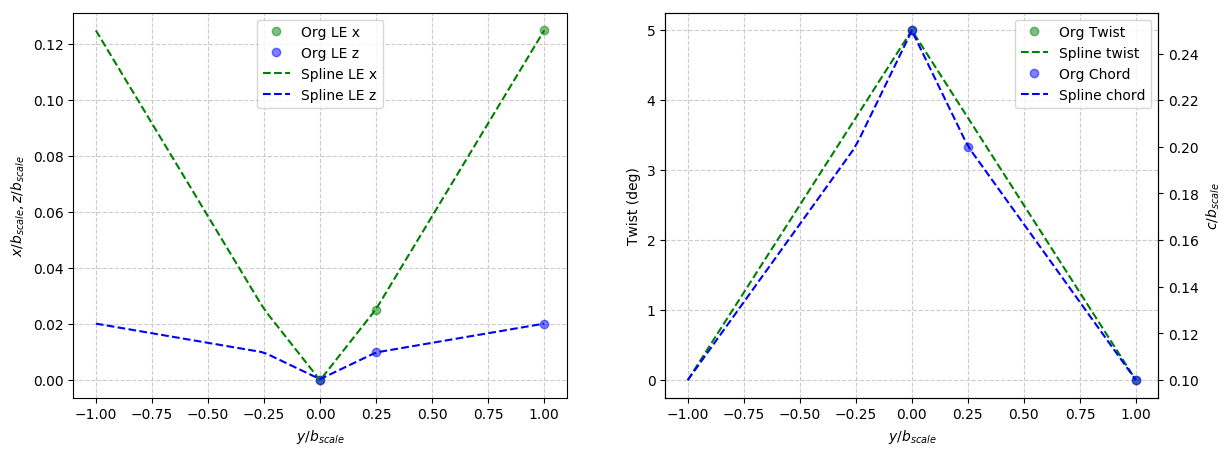

In [19]:
spl_k = 1                           # Spline order of distributions along span
spl_s = 0.0000001                   # Spline smoothing of distribution along span

# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
nothing

### Example &ndash; Wing, localized refinement mesh

Here is an example of how to defined a localized refinement. Instead of defining the a uniform discretization around the airfoil cross sections as
```julia
urfl_NDIVS = 25                     # Cells on upper side of airfoils
lrfl_NDIVS = 25                     # Cells on lower side of airfoils
```
we define the divisions as sections of discretization as follows:
```julia
urfl_NDIVS = [(0.25, 10,   10.0, false),       # Cells on upper side of airfoils
              (0.50,  7,    1.0, true),
              (0.25,  8, 1/10.0, false)]                    
lrfl_NDIVS = urfl_NDIVS                        # Cells on lower side of airfoils
```
The first section start at the leading edge, with a length of 0.25 and 10 divisions with an geometric expansion of 10.0. The second section is the center of airfoil, and the last one is the trailing edge:
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing03_2.gif" alt="Vid here" style="width: 900px;"/>

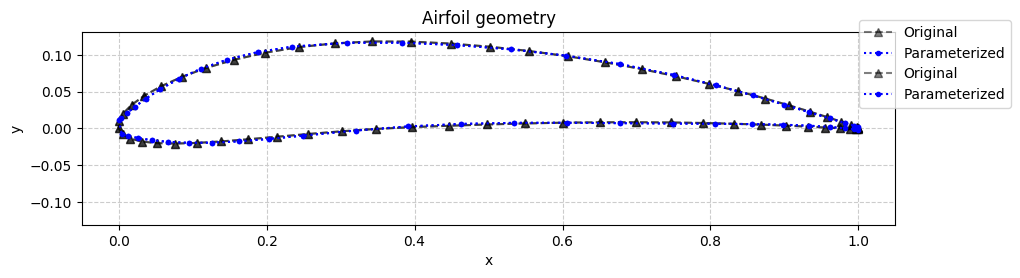

In [20]:
file_name = "paneledwing02"     # Output file name
save_path = "./"                # Save path

# ----------------- GEOMETRY DESCRIPTION -------------------------------------------
semispan = 10                       # (m) semi-span length

chords = [0.00 0.25;                # (semi-span position, chord c/semib)
          0.25 0.20;
          1.00 0.10]

twists = [0.0 5;                    # (semi-span position, twist (deg))
          1.0 0]

x_pos = [0.00 0;                    # (semi-span position, LE x-position x/semib)
         0.25 1/40;
         1.00 1/8;]

z_pos = [0.00 0;                    # (semi-span position, LE x-position x/semib)
         0.25 1/100;
         1.00 1/50]


airfoil_files = [(0.0, "naca6412.dat"), # (semi-span position, airfoil file)
                 (1.0, "naca6412.dat")]


# ----------------- MESHING PARAMETERS ---------------------------------------------
urfl_NDIVS = [(0.25, 10,   10.0, false),       # Cells on upper side of airfoils
              (0.50,  7,    1.0, true),
              (0.25,  8, 1/10.0, false)]                    
lrfl_NDIVS = urfl_NDIVS             # Cells on lower side of airfoils
b_NDIVS = 76                        # Span cells


# ----------------- LOFTING PARAMETERS ---------------------------------------------
b_low = -1.0                        # Lower bound of span lofting 
b_up = 1.0                          # Upper bound of span lofting
symmetric = true                    # Lofting symmetric about b=0
spl_k = 1                           # Spline order of distributions along span
spl_s = 0.0000001                   # Spline smoothing of distribution along span
verify_spline = false               # Plots the splined distributions
verify_rflspline = true             # Plots the splined airfoil cross sections


# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline,
                                        verify_rflspline=verify_rflspline
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

It works great, however, zooming in we realize that the leading edge of the wing is blunt, in spite of refinement. This is due to the splining of the airfoil cross sections smoothing out the high curvature at the leading edge (see below, top image) and failing to actually reconnect bottom and top surfaces. We fix this by decreasing the smoothness of the airfoil splines (see below, bottom image).
<img src="img/wing05_2.png" alt="Pic here" style="width: 900px;"/>

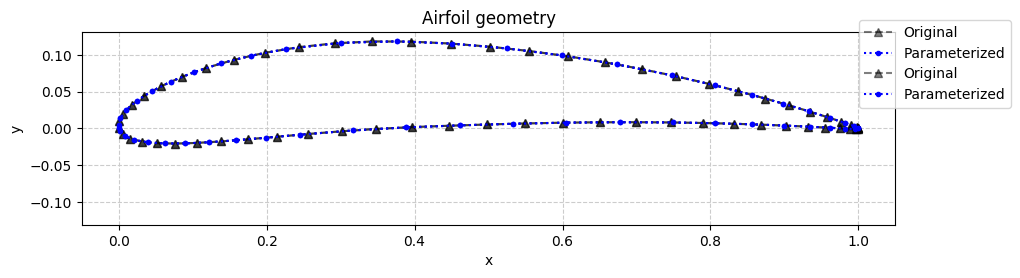

In [21]:
rflspl_s = 0.00000001               # Spline smoothing of airfoil cross sections.

# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline,
                                        verify_rflspline=verify_rflspline, 
                                        rflspl_s=rflspl_s
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

Finally, we can also refine the meshing towards both tips as shown below.
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing05.gif" alt="Vid here" style="width: 900px;"/>

In [22]:
b_NDIVS = [(1.0, 49, 20.0, true)]   # Span cell sections

# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoil_files, airfoil_path, urfl_NDIVS, lrfl_NDIVS, 
                                        semispan, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        verify_spline=verify_spline,
                                        verify_rflspline=false, 
                                        rflspl_s=rflspl_s
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

### Example &ndash; Propeller, nonsymmetric loft

Here we examplify the versatility of the lofting capabilities of our geometric engine by generating a two-bladed rotor that is lofted from tip to tip:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/prop07.gif" alt="Vid here" style="width: 900px;"/>

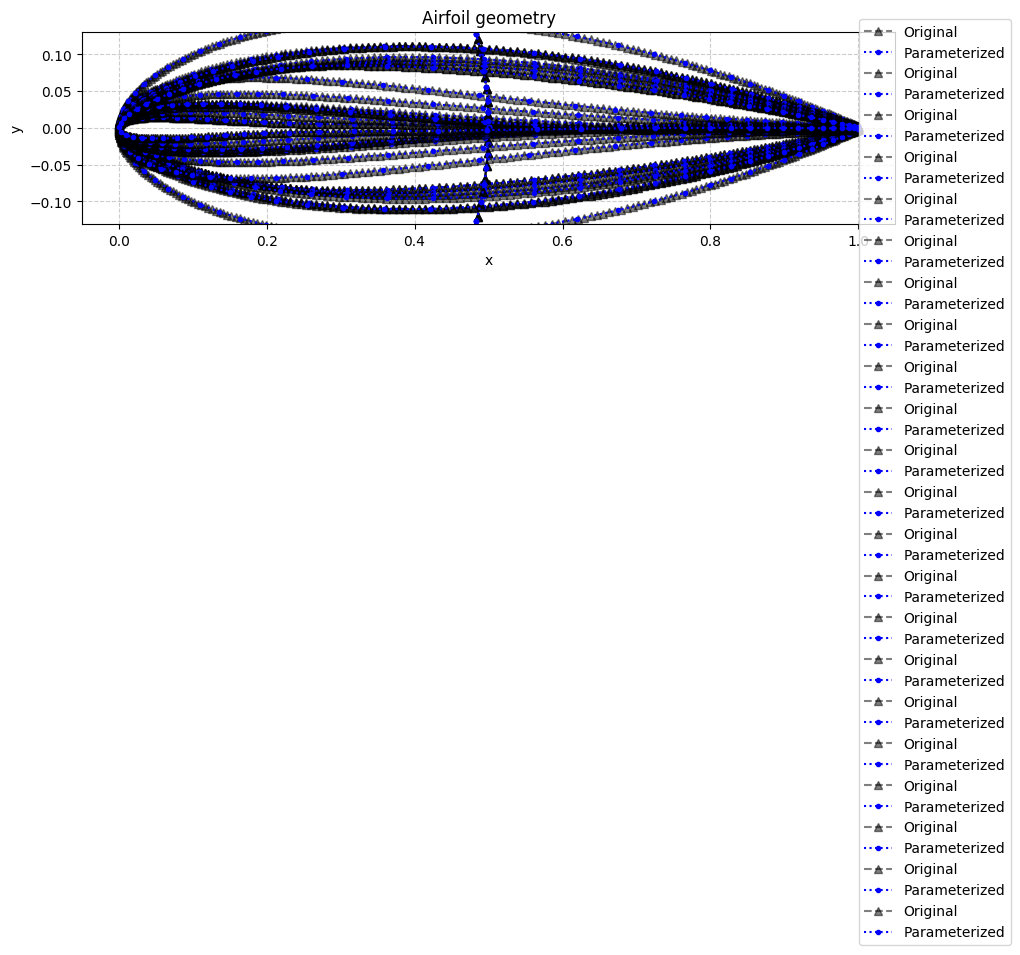

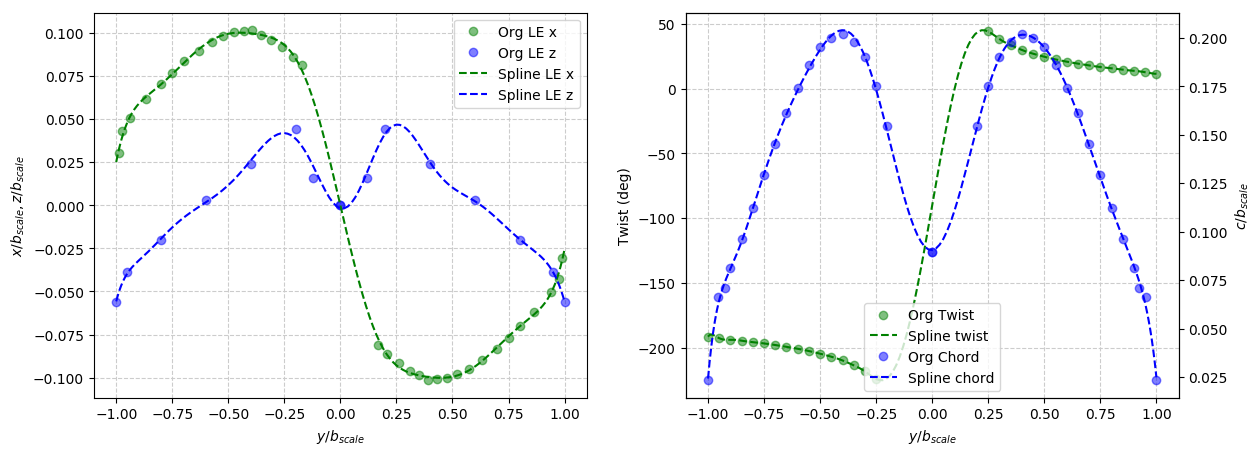

In [23]:
file_name = "prop00"     # Output file name
save_path = "./"                # Save path

# ----------------- GEOMETRY DESCRIPTION -------------------------------------------
Rtip = 10*0.0254/2                   # (m) Radius of propeller
        
chords = [0.0 0.134*2/3;                # (blade position, chord c/Rtip)
#             0.086 0.137106*5/6;
#             0.86 0.141*2/3;
#             0.16 0.144606;
            0.2 0.154291;
            0.25 0.175;
            0.3 0.19;
            0.35 0.198;
            0.4 0.202;
            0.45 0.2;
            0.5 0.195;
            0.55 0.186;
            0.6 0.174;
            0.65 0.161;
            0.7 0.145;
            0.75 0.129;
            0.8 0.112;
            0.85 0.096;
            0.9 0.081;
            0.9245 0.071125;
            0.954 0.066125;
            1.0 0.0233333]

twists = [                     # (blade position, twist (deg))
#             0.01 0;                
#             0.04715 22.0;
#             0.088145 30.0;
#             0.15 37.86;
#             0.2 45.82;
            0.25 44.19;
            0.3 38.35;
            0.35 33.64;
            0.4 29.9;
            0.45 27.02;
            0.5 24.67;
            0.55 22.62;
            0.6 20.88;
            0.65 19.36;
            0.7 17.98;
            0.75 16.74;
            0.8 15.79;
            0.85 14.64;
            0.9 13.86;
            0.95 12.72;
            1.0 11.53]

x_pos = [                        # (blade position, LE x-position x/Rtip)
#             0.0 0.0;
#             0.0266906 -0.0675531*0;      
#             0.0993744 -0.0781078*0;
            0.16992 -0.0810668;
            0.209422 -0.0860351;
            0.260681 -0.0914966;
            0.310887 -0.0958101;
            0.352557 -0.0986618;
            0.39209 -0.101424;
            0.430601 -0.100831;
            0.473388 -0.100419;
            0.521551 -0.0980235;
            0.574004 -0.0947046;
            0.632903 -0.0894484;
            0.69823 -0.083358;
            0.7518 -0.0767745;
            0.801094 -0.0700117;
            0.865384 -0.0616702;
            0.94041 -0.0504677;
            0.973671 -0.0430323;
            0.986802 -0.030395]

z_pos = [0.0 0.0;                  # (blade position, LE x-position x/Rtip)
#             0.075 -0.003*0;
            0.12 0.016;
            0.2 0.044;
            0.4 0.024;
            0.6 0.00278494;
            0.8 -0.02;
            0.95 -0.0388821;
            1.0 -0.056]


airfoil_files = [                    # (blade position, airfoil file)
            (0.0, "Cyl2.csv"),  
            (0.02, "Cyl2.csv"),  
#             (0.075, "rflsec7.csv"),
#             (0.12, "rflsec6.csv"),
            (0.2, "naca5521.csv"),
            (0.3, "naca4515.csv"),
            (0.4, "naca5513.csv"),
            (0.5, "naca5513.csv"),
            (0.6, "naca4512.csv"),
            (0.7, "naca4511.csv"),
            (0.8, "naca4410.csv"),
            (0.9, "naca4309.csv"),
            (1.0, "naca4309.csv")
                ]

# Mirrors distribution for opposite blade
auxM = [chords[i,j] for i in size(chords,1):-1:1, j in 1:2]
chords = vcat(auxM.*[[-1, 1][j] for i in 1:size(auxM,1), j in 1:2], chords)

auxM = [twists[i,j] for i in size(twists,1):-1:1, j in 1:2]
auxM[:,2] .+= 180
twists = vcat(auxM.*[[-1, -1][j] for i in 1:size(auxM,1), j in 1:2], twists)

auxM = [x_pos[i,j] for i in size(x_pos,1):-1:1, j in 1:2]
x_pos = vcat(auxM.*[[-1, -1][j] for i in 1:size(auxM,1), j in 1:2], x_pos)

auxM = [z_pos[i,j] for i in size(z_pos,1):-1:1, j in 1:2]
z_pos = vcat(auxM.*[[-1, 1][j] for i in 1:size(auxM,1), j in 1:2], z_pos)

# auxM = reverse([(-pos, afile) for (pos, afile) in airfoil_files])
# airfoil_files = vcat(auxM, airfoil_files)

# Some parameters regarding the format of the airfoil files
header_len = 0
delim = ","

# Reads and reflect the airfoils of opposite blade
airfoils = [(pos, pnl.gt.readcontour(f_name; path=airfoil_path, 
                                      header_len=header_len, delim=delim, 
                                      output="matrix"))
                              for (pos, f_name) in airfoil_files]

auxM = [(-pos, M .* [[1, -1][j] for i in 1:size(M,1), j in 1:2]) for (pos, M) in airfoils]
airfoils = vcat(reverse(auxM), airfoils)


# ----------------- MESHING PARAMETERS ---------------------------------------------
N=4                                         # Scaling of number of cells
urfl_NDIVS = [(0.10, 3*N, 5.0, false),      # Cells on upper side of airfoils
              (0.30, 3*N, 2.0, true),
              (0.10, 3*N, 1/5, false)]                   
lrfl_NDIVS = urfl_NDIVS                     # Cells on lower side of airfoils
b_NDIVS = [(1.0, 50*N, 5.0, true)]          # Span cells


# ----------------- LOFTING PARAMETERS ---------------------------------------------
b_low = -1.0                        # Lower bound of span lofting 
b_up = 1.0                          # Upper bound of span lofting
symmetric = false                   # Lofting symmetric about b=0
spl_k = 5                           # Spline order of distributions along span
spl_s = 0.0001                      # Spline smoothing of distribution along span
rflspl_s = 0.00001                  # Spline smoothing of airfoil cross sections.
verify_spline = true                # Plots the splined distributions
verify_rflspline = true             # Plots the splined airfoil cross sections


# ----------------- GENERATE WING --------------------------------------------------
wing = pnl.gt.generate_loft(airfoils, urfl_NDIVS, lrfl_NDIVS, 
                                        Rtip, b_low, b_up, b_NDIVS, 
                                        chords, twists, x_pos, z_pos; 
                                        symmetric=symmetric, 
                                        spl_k=spl_k, spl_s=spl_s,
                                        rflspl_s=rflspl_s,
                                        verify_spline=verify_spline,
                                        verify_rflspline=verify_rflspline
                                    )

# Save vtk and call paraview
pnl.gt.save(wing, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

## Surface of Revolution Method

Following the concept of bodies of revolution where a contour is revolved around an axis, this method generates the surface of such revolution. All types detailed above implement some type of wrapper of the following revolving method in `GeometricTools`:

In [24]:
? pnl.gt.surface_revolution

`surface_revolution(profile, thetaNDIVS; loop_dim=0, axis_angle=0, low_a=0, up_a=360, save_path=nothing, paraview=true, file_name="myrev")`

Receives a contour to revolve around an axis generating a surface of revolution.

**ARGUMENTS**

  * `profile::Array{Float64,2}`   : Contour to revolve. These are two-                                 dimensional points in the YZ-plane that will                                 get revolve around the Z-axis.
  * `thetaNDIVS::Int64`           : Number of angle-sections (cells) in the                                 revolution.

**OPTIONAL ARGUMENTS**

  * `loop_dim::Int64=0`           : Whether to loop any dimension of the                                 parametric grid.
  * `axis_angle::Float64=0`       : Tilting angle (deg) about the Z-axis to                                 revolve the contour.
  * `low_a::Float64=0`            : Lower bound of angle (deg) of revolution.
  * `up_a::Float64=0`             : Upper bound of angle (deg) of revolution.


OBSERVATION: The following examples show how to use the revolution method directly from the GeometricTools package. In order to use this grid in the definition of a body, the quadrilateral panels must by transformed into triangular panels through `gt.GridTriangleSurface(orggrid, dimsplit)`.

### Example &mdash; Rotor hub

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub00.gif" alt="Vid here" style="width: 800px;"/>

First, we need a profile to revolve consisting of a collection of points. This can be predefined and read as a csv file (for example), or defined programmatically. Here we exemplify how to define the contour programmatically:

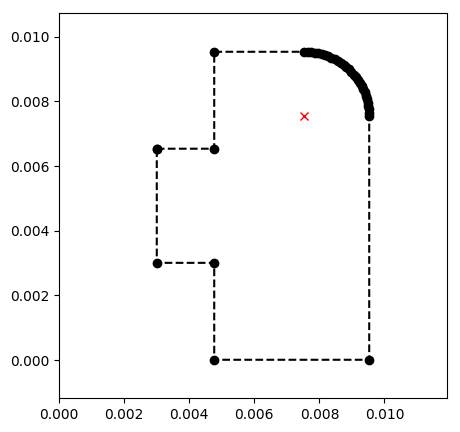

In [25]:
Rhub = 0.375 * 0.02542        # (m) radius of hub
Rinn = Rhub / 2               # (m) inner hole radius
Rsec1 = Rinn                # (m) radius of first hole
Rsec2 = 3 / 1000              # (m) radius of second hole
Thub = Rhub                 # (m) thickness of hub
dsec1 = 3 / 1000              # (m) depth of first hole

Rfillet = 2 / 1000            # (m) Fillet radius
Nfillet = 30                # Points along fillet
Cfillet = [Rhub, Thub] .- Rfillet      # Center of fillet

points_fillet = [Cfillet .+ Rfillet * [sin(a), cos(a)] 
                        for a in range(0, stop=pi/2, length=Nfillet)]

points = hcat(
              [Rsec2, Thub-dsec1],
              [Rsec1, Thub-dsec1],
              [Rsec1, Thub],
              points_fillet...,
              [Rhub, 0],
              [Rsec1, 0],
              [Rsec1, dsec1],
              [Rsec2, dsec1],
              [Rsec2, Thub-dsec1]
             )'

x = [points[i,1] for i in 1:size(points,1)]
y = [points[i,2] for i in 1:size(points,1)]

PyPlot.figure(figsize=(5,5))
PyPlot.plot(x,y, "--ok")
PyPlot.plot([Cfillet[1]], [Cfillet[2]], "xr")
PyPlot.xlim([0, Rhub*1.25])
PyPlot.ylim([-Rhub*0.125, Rhub*1.125]);

Having the profile stored under `points`, we simply call the function `pnl.surface_revolution` or any of its Body wrappers as follows:

In [26]:
save_path = "./"
file_name = "hub00"

thetaNDIVS = 180          # Number of angular sections
loop_dim = 1             # Loops the parametric grid

# Creates body of revolution
grid = pnl.gt.surface_revolution(points, thetaNDIVS; loop_dim=loop_dim)

# Save vtk and call paraview
pnl.gt.save(grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

### Example &mdash; Tilted revolution

By using the optional argument `axis_angle` we can tilt the angle about which to do the revolution. To exemplify this, using the previous contour we will tilting the axis by $90^\circ$ about the $z$-axis, resulting in a revolution about the $y$-axis:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub02.gif" alt="Vid here" style="width: 800px;"/>

In [27]:
axis_angle = 90          # Axis tilting

grid = pnl.gt.surface_revolution(points, thetaNDIVS; 
                                    loop_dim=loop_dim, 
                                    axis_angle=axis_angle)

# Save vtk and call paraview
pnl.gt.save(grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

And here is what we get by tilting the axis by $45^\circ$ about the $z$-axis:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub03.gif" alt="Vid here" style="width: 800px;"/>

In [28]:
axis_angle = 45          # Axis tilting

grid = pnl.gt.surface_revolution(points, thetaNDIVS; 
                                    loop_dim=loop_dim, 
                                    axis_angle=axis_angle)

# Save vtk and call paraview
pnl.gt.save(grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

### Example &mdash; Incomplete revolution

Using the arguments `low_a` and `up_a` we can set the lower and upper bound angles of the revolution to create an incomplete body of revolution:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub04.gif" alt="Vid here" style="width: 800px;"/>

In [29]:
thetaNDIVS = 45          # Number of angular sections
loop_dim = 1             # Loops the parametric grid
low_a = -45              # Lower bound of revolution angle
up_a = 45                # Upper bound of revolution angle

grid = pnl.gt.surface_revolution(points, thetaNDIVS; 
                                    loop_dim=loop_dim, 
                                    low_a=low_a, up_a=up_a)

# Save vtk and call paraview
pnl.gt.save(grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

## Space Transformation Method

Complex geometries can be defined manually by applying a predefined or user-defined space transformation on a `Grid` object.

The following predefined nonlinear [orthogonal space transformations](https://en.wikipedia.org/wiki/Orthogonal_coordinates) are implemented in `GeometricTools`:
* `cylindrical3D(X)`
* `cylindrical2D(X)`
* `spherical3D(X)`
* `parabolic3D(X)`
* `paraboloidal3D(X)`
* `elliptic3D(X; a=1)`
* `prolate3D(X; a=1)`
* `oblate3D(X; a=1)`
* `bipolar3D(X; a=1)`
* `toroidal3D(X; a=1)`
* `conical3D(X; b=2, c=1)`. 

### Example &ndash; Sphere, predefined transformation.

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/sphere00.gif" alt="Vid here" style="width: 900px;"/>

In [30]:
file_name = "sphere00"
save_path = "./"

# Parameters
R = 1.0                          # (m) radius of sphere
P_min = [0, 0, 0]                # Lower bounds of (theta, phi, dummy)
P_max = [pi, 2*pi, 0]            # Upper bounds of (theta, phi, dummy)
NDIVS = [25, 50, 0]              # Number of divisions (cells) of (theta, phi, dummy)
loop_dim = 2                     # Coordinate to loop (1==theta)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Transforms the grid into a spherical cartesian space
my_transform(X) = pnl.gt.spherical3D(vcat(R, X[1:2]))
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)


# Save vtk and call paraview
pnl.gt.save(triang_grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

### Example &ndash; Box, user-defined transformation.

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/box00.gif" alt="Vid here" style="width: 900px;"/>

In [31]:
file_name = "box00"
save_path = "./"

# Parameters
L = 1.0                          # (m) side's length
P_min = [-0.95, 0, 0]            # Lower bounds of (x, y, dummy)
P_max = [.95, 4.0, 0]            # Upper bounds of (x, y, dummy)
# NDIVS = [24, 20, 0]            # Number of divisions (cells) of (x, y, dummy)
N = 3
NDIVS = [
            [(0.45, 3*N, 1/2, false), 
                (1.0, 6*N, 2.0, true), 
                (0.45, 3*N, 2.0, false)],
            [(0.25, 6*N, 2.0, true) for i in 1:4],
            [(1.0, 0, 0.0, false)]
        ]
loop_dim = 2                     # Coordinate to loop (2==y)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Axis on every face
Oaxis = [gt.rotation_matrix2(-a, 0, 0) for a in [90, 0, -90, -180]]

# Center of every face
O = L*[zeros(3), [0, 0, 1.0], [0, 1, 1.0], [0, 1, 0.0]]

# Axis of side sections
Oaxis_sec = [gt.rotation_matrix2(angles...)*Oaxis[i] 
                for (i, angles) in enumerate([(0,-90,0), (0,-90,0), (0,-90,0), (0,-90,0)])]

# Center of side sections
O_sec = [O[i]+L/2*Oaxis[i][2,:] for i in 1:4]

# Transformation function
function my_transform(X)
    
    # Identifies the face
    face = Int(floor(X[2]+1))
    
    if face<=0 || face>4
        error("Logic error! Invalid face $face")
    end
    
    # Identifies the side (-1->left, 0->center, 1->right)
    side = sign(X[1])*(abs(X[1])>0.5)
    
    if side==0
        return gt.countertransform(L*[X[1], X[2]-(face-1), 0], inv(Oaxis[face]), O[face])
    else
        mod_X = [abs(X[1])-0.5, X[2]-(face-1)-0.5, 0]
        mod_X[2] *= 1 - mod_X[1]/0.5
        return gt.countertransform(L*[mod_X[1], side*mod_X[2], 0], 
                                        inv([1 0 0; 0 side 0; 0 0 side]*Oaxis_sec[face]), 
                                        O_sec[face] + L/2*[side, 0, 0])
    end
end

# Converts the parametric grid into a box
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)

# Save vtk and call paraview
pnl.gt.save(triang_grid, file_name; path=save_path)
run(`paraview --data=$(joinpath(save_path, file_name)).vtk`)
run(`rm -f $(joinpath(save_path, file_name)).vtk`)
nothing

# Panel Types

In this section we describe the different panel types that are used as elements in the different aerodynamics solvers.

## Panel Definition

Starting from a **nonplanar**-quadrilateral grid surface, the `GridTriangleSurface` type splits every quadrilateral panel into two **planar** triangular panels shown in green and red in the following figure:

<img src="img/panel01.png" alt="Pic here" style="width: 250px;"/>

Numbers correspond to the indexing of the nodes of the quadrilateral (black) and both triangles (green and red). Arrows show the direction of tangential vectors. The normal vector is calculated as the cross product between the vectors between nodes 1-2 and 1-3 as $\hat{n}=\hat{u}_{12}\times\hat{u}_{13}$. A second tangent vector, termed the "oblique vector" $\hat{o}$, is defined as $\hat{o}=\hat{n}\times\hat{t}$. With this definition, the normal of the panel depends of the indexing of the vertices, where **a counterclockwise indexing defines the normal out of the screen**. 

## Constant-strength Source Panel

From Hess, J. L., & Smith, A. M. O. (1967), *Calculation of potential flow about arbitrary bodies*, given the following constant-strength, **planar** polygonal panel of unitary strength 

<img src="img/panel00.png" alt="Pic here" style="width: 400px;"/>

its potential at an arbitrary point $(x,y,z)$ is calculated as 

\begin{align}
    \varphi=\int\limits_{A}\frac{\text{d}A}{r}
,\end{align}
with $r=\sqrt{(x-\xi)^2 + (y-\eta)^2 + z^2}$.

The velocity it induces at $(x,y,z)$ is calculated as

\begin{align}
        \bullet & V_x = -\frac{\partial\varphi}{\partial x} = -\sum\limits_{i=1}^n S_i Q_i
    \\
        \bullet & V_y = -\frac{\partial\varphi}{\partial y} = \sum\limits_{i=1}^n C_i Q_i
    \\
        \bullet & V_z = -\frac{\partial\varphi}{\partial z} = \text{sgn}(z) [\Delta\theta -
                                                                    \sum\limits_{i=1}^n J_i]
,\end{align}
with $n$ the number of vertices in the polygon, the subindex $i$ a shorthand of double indexation defined as $i=(i,i+1)$ if $i\neq n$ and $i=(i,1)$ otherwise, and the remaining terms defined as follows:

\begin{align}
        \bullet & S_{i,j} = \frac{\eta_j - \eta_i}{d_{i,j}}
    \\
        \bullet & C_{i,j} = \frac{\xi_j - \xi_i}{d_{i,j}}
    \\
        \bullet & Q_{i,j} = \ln{\left(\frac{ r_i+r_j+d_{i,j} }{ r_i+r_j-d_{i,j} }\right)}
    \\
        \bullet & J_{i,j} = \arctan{\left(\frac{ 
                                R_{i,j}\lvert z \rvert( r_i s_{i,j}^{(j)} - r_j s_{i,j}^{(i)}) 
                            }{ 
                                r_i r_j R_{i,j}^2 + z^2 s_{i,j}^{(j)} s_{i,j}^{(i)}
                            }\right)}
    \\
        \bullet & s_{i,j}^{(k)} = (\xi_k - x)C_{i,j} + (\eta_k - y)S_{i,j}
    \\
        \bullet & R_{i,j} = (x - \xi_i)S_{i,j} - (y - \eta_i)C_{i,j}
    \\
        \bullet & d_{i,j} = \sqrt{(\xi_j-\xi_i)^2 + (\eta_j-\eta_i)^2}
    \\
        \bullet & r_i = \sqrt{(x-\xi_i)^2 + (y-\eta_i)^2 + z^2}
.\end{align}

and $\Delta\theta=2\pi$ if $x,y,0$ lies inside the quadrilateral, $\Delta\theta=0$ if not. Hess & Smith mentions that the point lies inside the quadrilateral iff all $R_{i}$ are positive.

FLOWPanel's implementation does that calculation of each panel's influence in the following coordinate system:

<img src="img/panel04.png" alt="Pic here" style="width: 400px;"/>

with $\hat{\eta}$ defined in the direction between nodes 1 and 2 as $\hat{\eta}=\hat{u}_{12}$ (which is also the tangent vector $\hat{t}$ of the panel), the z direction is defined as $\hat{z}=-\hat{u}_{12}\times\hat{u}_{13}$, and $\hat{\xi}$ defined as $\hat{\xi}=-\hat{z}\times\hat{\eta}$. This vectors are calculated from the panel units vectors $\hat{t}, \hat{o}, \hat{n}$ (defined above) through the following relations:
\begin{align}
    \bullet \quad & \hat{\eta} = \hat{t} \\
    \bullet \quad & \hat{z} = -\hat{n} \\
    \bullet \quad & \hat{\xi} = \hat{o} \\
\end{align}


Finally, the velocity in the global coordinate system is obtained as

\begin{align}\boxed{
    {\bf V}_{\text{ind}}\left( {\bf x} \right) = \sigma \left[
        V_x\left({\bf f}\left( {\bf x} \right)\right)\hat{\xi} +
        V_y\left({\bf f}\left( {\bf x} \right)\right)\hat{\eta} +
        V_z\left({\bf f}\left( {\bf x} \right)\right)\hat{z}
    \right]
    }
,\end{align}

with ${\bf f}$ the transformation function from the global coordinate system to the panel's coordinate system, and $\sigma$ the strength of the panel if non-unitary. For the sake of simplicity, the equation is then writed as 

\begin{align}\boxed{
        {\bf V}_{\text{ind}}\left( {\bf x} \right) = \sigma {\bf G}\left( {\bf x} \right)
    }
,\end{align}

with ${\bf G}$ containing the geometric information of the panel.

**ASSUMPTIONS**

* The panel is a polygon of $n$ number of vertices with $n\ge3$.
* The polygon is planar, *i.e.,* all vertices lay on the same plane.
* Vectors betweens nodes 1 and 2 and nodes 1 and 3 are not collinear.
* **The polygon must be concave**.

**OBSERVATIONS**
* $Q_{i,j}$ makes this formulation singular at all vertices and edges of a panel; hence, I added a small epsilon to the denominator of the log arguments as to avoid the singularity.

### Verification

**Triangular Panel**
<img src="img/verpanel00.png" alt="Pic here" style="width: 900px;"/>

**Arbitrary Planar Concave Polygonal Panel**
<img src="img/verpanel01.png" alt="Pic here" style="width: 900px;"/>

**Rotated Triangular Panel**
<img src="img/verpanel02.png" alt="Pic here" style="width: 900px;"/>

## Constant Doublet Panel

Currently there is an implementation of a doublet panel type in FLOWVPM following Katz and Plotkin, *Low-speed Aerodynamics*, Sec. 10.4.2, however no verification and validation has been done on it.

## Vortex Ring Panel

From Katz and Plotkin, *Low-speed Aerodynamics*, Sec. 10.4.5.

The differential velocity induced at a position $\bf x$ by an infinitesimal section $\delta {\bf l}$ of a line vortex is 

\begin{align}
    \delta {\bf u} \left( {\bf x} \right) = -\frac{\Gamma}{4\pi} \frac{\delta {\bf l}\times {\bf r}}{r^3}
\end{align}

with $\bf r$ the vector between ${\bf x}$ and the position of $\delta {\bf l}$.


Then, the velocity induced by of the line vortex of constant strength pointing from point ${\bf p}_1$ to point ${\bf p}_2$ is calculated as the integral of $\delta {\bf u}$, resulting in

\begin{align}
    {\bf u}_{1,2} \left( {\bf x} \right) & = -\frac{\Gamma}{4\pi} 
            \frac{{\bf r}_1 \times {\bf r}_2}{ \Vert {\bf r}_1 \times {\bf r}_2 \Vert^2}
            {\bf r}_{2,1} \cdot \left(
                \frac{{\bf r}_1}{r_1} - \frac{{\bf r}_2}{r_2}
            \right)
    \\
         & = \Gamma \mathbf{g}_{1,2}\left( {\bf x} \right)
,\end{align}

with ${\bf r}_{2,1} = {\bf p}_1-{\bf p}_2$, ${\bf r}_1 = {\bf x} - {\bf p}_1$, ${\bf r}_2 = {\bf x} - {\bf p}_2$.

<img src="img/vortex01.png" alt="Pic here" style="width: 250px;"/>

A vortex ring panel is then defined as a collection of line vortices along the edges of the panel. For a positive $\Gamma$, the **velocity induced at the center of the panel would point in the direction of the normal of the panel**:

<img src="img/vring02.png" alt="Pic here" style="width: 250px;"/>

and the velocity that it induces at $\mathbf{x}$ is

\begin{align}
    \mathbf{u}_\text{ring}\left( \mathbf{x} \right) 
    & = \sum\limits_{i=1}^N
        \mathbf{u}_i\left( \mathbf{x} \right)
    \\
    & = \sum\limits_{i=1}^N 
                \Gamma \mathbf{g}_i\left( \mathbf{x} \right)
    \\
    & = \Gamma \mathbf{g}_\text{ring} \left( \mathbf{x} \right)
, \end{align}
with $\mathbf{u}_i = \mathbf{u}_{i,i+1}$ if $i\neq N$, and $\mathbf{u}_N = \mathbf{u}_{N,1}$ otherwise.

**OBSERVATIONS**
* The ring can be any polygon (any number of edges, planar or non-planar, convex or concave).
* The method poses singularities at each node, hence I have defined a regularizing radius.
* The method poses a singularity along each line, hence I have defined a radius around every line vortex where the velocity induced is zero (this actually overwrites the regularization of the previous point).
* Having a positive strength self-inducing a velocity in the direction of the normal of the panel **defines the vortex ring going counterclockwise** as shown in the picture above.
* The `PanelSolver.Vvortexring(nodes, strength, targets, Vs; closed_ring=false)` takes the optional argument of not closing the ring (`closed_ring=false`), which allows results in the following vortex line from the example above:
<img src="img/vring03.png" alt="Pic here" style="width: 250px;"/>

### Verification

**Flow Around Vortex Line**
<img src="img/vortex00_2.png" alt="Pic here" style="width: 900px;"/>

**Induced Flow Direction**

<img src="img/vringver02.png" alt="Pic here" style="width: 900px;"/>

# Solvers

## Non-lifting Body Solver

A body that produces no lift would only require source panels. Let's determine the system of equations for calculating the strengths of a constant-strength source body such as to satisfy the no-flow-through boundary condition.



Having a body of N panels, we define $N$ control points (one at each panel) were we impose to condition of no-flow-through. Let ${\bf x}_i$ be the position of the $i$-th control point, $\hat{n}_i$ the normal of the panel associated to it, ${\bf V}_i = {\bf V}_\infty\left( {\bf x}_i \right)$ the freestream velocity at the control point, and $({\bf V}_{\text{ind}})_i$ the total velocity induced at the control point. $({\bf V}_{\text{ind}})_i$ is calculated as the sum of the velocities induced by every panel at ${\bf x}_i$ as

\begin{align}
    ({\bf V}_{\text{ind}})_i = \sum\limits_j^N V_{\text{ind}}^{(j)} \left( {\bf x}_i \right)
,\end{align}

with ${\bf V}_{\text{ind}}^{(j)}$ the velocity induced by the $j$-th panel.

The no-flow-condition is then imposed at the $i$-th control point as

\begin{align}
        ({\bf V}_{\text{ind}})_i \cdot \hat{n}_i & = - {\bf V}_i \cdot \hat{n}_i
    \\ \Leftrightarrow
        \sum\limits_j^N {\bf V}_{\text{ind}}^{(j)} \left( {\bf x}_i \right
            ) \cdot \hat{n}_i 
                & = - {\bf V}_\infty\left( {\bf x}_i \right) \cdot \hat{n}_i
    \\ \Leftrightarrow
        \sum\limits_j^N \sigma_j{\bf G}_j \left( {\bf x}_i \right
            ) \cdot \hat{n}_i 
                & = - {\bf V}_\infty\left( {\bf x}_i \right) \cdot \hat{n}_i
    \\ \Leftrightarrow
        \begin{bmatrix}
            {\bf G}_1  \left( {\bf x}_i \right) \cdot \hat{n}_i 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_i \right) \cdot \hat{n}_i
        \end{bmatrix}
        \begin{bmatrix}
            \sigma_1 \\ \vdots \\ \sigma_N
        \end{bmatrix}
                & = - {\bf V}_\infty\left( {\bf x}_i \right) \cdot \hat{n}_i
\end{align}


In order to solve for the $N$ unkown sigmas, we impose the condition in all $N$ control points, resulting in the following system of equations:

\begin{align}
        \begin{bmatrix}
            {\bf G}_1  \left( {\bf x}_1 \right) \cdot \hat{n}_1 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_1 \right) \cdot \hat{n}_1
        \\
                \vdots & \ddots &
        \\
            {\bf G}_1  \left( {\bf x}_N \right) \cdot \hat{n}_N 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_N \right) \cdot \hat{n}_N
        \end{bmatrix}
        \begin{bmatrix}
            \sigma_1 \\ \vdots \\ \sigma_N
        \end{bmatrix}
    & = - 
        \begin{bmatrix}
            {\bf V}_\infty\left( {\bf x}_1 \right) \cdot \hat{n}_1
        \\
            \vdots
        \\
            {\bf V}_\infty\left( {\bf x}_N \right) \cdot \hat{n}_N
        \end{bmatrix}
\end{align}

or 

\begin{align} \boxed{
        \mathbb{G}\boldsymbol\Sigma = -\boldsymbol\Lambda,
        \qquad \text{ with }
        \qquad (\mathbb{G})_{ij} = {\bf G}_j\left( {\bf x}_i \right) \cdot \hat{n}_i,
        \qquad (\boldsymbol\Sigma)_j = \sigma_j,
        \qquad (\boldsymbol\Lambda)_i = {\bf V}_\infty\left( {\bf x}_i \right) \cdot \hat{n}_i
    }
\end{align}

The geometric matrix $\mathbb{G}$ takes the geometric factors of induced velocity of $N$ panels on $N$ control points, its construction is of computational complexity $\mathcal{O}\left( N^2\right)$. Since the paneled body would at most suffer linear transformations in its geometry (rotation and translations), it is convenient to calculate this matrix only once at the initial setup of the nonlifting body in the local reference frame of the body, and subsequently solve for the strengths by transforming the boundary conditions into the body's reference frame as 

\begin{align}
    (\boldsymbol\Lambda)_i = {\bf f}\left(
                                    {\bf V}_\infty\left( 
                                        {\bf g}\left(
                                            {\bf x}_i \right) 
                                        \right)
                                    \right) \cdot \hat{n}_i
,\end{align}

with ${\bf f}$ the function that transforms a vector direction (rotation) from the global coordinate system into the body's local coordinate system, and ${\bf g}$ the function that transforms a vector (translation+rotation) from the local into the global coordinate system.

**CORRECTION:** If all ${\bf V}_\infty, {\bf x}_i, \hat{n}_i$ in the right hand side are in the global coordinate system, there is no need to convert any to the local coordinate system.

**OBSERVATIONS**
* The velocity at the surface of a panel is somewhat funky due to floating point precision, so I displaced the control points slightly in the normal direction as to be above of each panel.

### Verification &ndash; Rotor hub

Here we use the rotor hub as the geometry previously used to exemplify bodies of revolutions, and solve the flow around it with source panels:

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub02_2.gif" alt="Vid here" style="width: 900px;"/>

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/hub03_2.gif" alt="Vid here" style="width: 900px;"/>

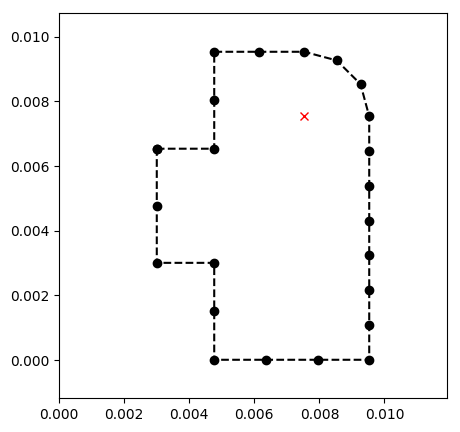

In [32]:
Rhub = 0.375*0.02542        # (m) radius of hub
Rinn = Rhub/2               # (m) inner hole radius
Rsec1 = Rinn                # (m) radius of first hole
Rsec2 = 3/1000              # (m) radius of second hole
Thub = Rhub                 # (m) thickness of hub
dsec1 = 3/1000              # (m) depth of first hole

Rfillet = 2/1000            # (m) Fillet radius
Nfillet = 4                 # Points along fillet
Cfillet = [Rhub, Thub] .- Rfillet      # Center of fillet

# Points along each section
Nsec = 1*[2, 3, 3, Nfillet, 8, 4, 3, 2, 3]

# Generates fillet
points_fillet = [Cfillet .+ Rfillet * [sin(a), cos(a)] 
                        for a in range(0, stop=pi/2, length=Nsec[4])]

# Boundary points of each section
sections = [
              [Rsec2, Thub-dsec1],
              [Rsec1, Thub-dsec1],
              [Rsec1, Thub],
              points_fillet[1],
              points_fillet[end],
              [Rhub, 0],
              [Rsec1, 0],
              [Rsec1, dsec1],
              [Rsec2, dsec1],
              [Rsec2, Thub-dsec1]
            ]

# Generates points per section
points = []
for i in 1:size(sections, 1)-1
    
    if i==4
        push!(points, points_fillet[1:end-1])
    else
        p1, p2 = sections[i], sections[i+1]
        this_points = [p1 + r * (p2 - p1) for r in range(0, stop=1, length=Nsec[i])]
        push!(points, this_points[1:end-1])
    end
    
end

# Unfolds sections into one array
points = vcat(points...)

# Closes the contour
push!(points, points[1])

# Converts the array of arrays into a matrix
points = hcat(points...)'

x = [points[i,1] for i in 1:size(points,1)]
y = [points[i,2] for i in 1:size(points,1)]

PyPlot.figure(figsize=(5,5))
PyPlot.plot(x,y, "--ok")
PyPlot.plot([Cfillet[1]], [Cfillet[2]], "xr")
PyPlot.xlim([0, Rhub*1.25])
PyPlot.ylim([-Rhub*0.125, Rhub*1.125]);

In [34]:
save_path = "./"
file_name = "hub00"
calc_fdom = true

thetaNDIVS = 20          # Number of angular sections

# Creates body of revolution
body = pnl.generate_revolution_nonliftbody(points, thetaNDIVS)

# Rotates the body aligning it with the x-axis
M = gt.rotation_matrix(0, 90, 0)
gt.lintransform!(body.grid, M, zeros(3))


# Adds normal vector field
pnl.gt.add_field(body.grid, "normal", "vector",
                    [pnl.gt.get_normal(body.grid, i) for i in 1:body.ncells], "cell")

pnl.gt.add_field(body.grid, "cellindex", "scalar",
                    [i for i in 1:body.ncells], "cell")
pnl.gt.add_field(body.grid, "nodeindex", "scalar",
                    [i for i in 1:body.nnodes], "node")

# Freestream at every control point
Vinf = 25.0 * [1, 0, 0]
Vinfs = [Vinf for i in 1:body.ncells]
pnl.solve(body, Vinfs)

# Adds surface velocity field
CPs = [pnl.get_controlpoint(body, i) for i in 1:body.ncells]
Vsurf = [Vinf for i in 1:size(CPs,1)]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
    pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), CPs, Vsurf)
end
point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]

if calc_fdom
    # Creates a fluid domain grid
    P_min = [-3*Thub, -2*Rhub, -2*Rhub]
    P_max = [2*Thub, 2*Rhub, 2*Rhub]
    NDIVS = 2 * [10, 10, 10]
    fdom = gt.Grid(P_min, P_max, NDIVS)
    targets = [gt.get_node(fdom, i) for i in 1:fdom.nnodes]
    V = [Vinf for i in 1:fdom.nnodes]
    for i in 1:body.ncells
        pnodes = gt.get_cellnodes(body.grid, i)
        pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), targets, V)
    end
    
    # Makes zero any velocities inside the geometry
    for i in 1:fdom.nnodes
        X = gt.get_node(fdom, i)
        if X[1] >= -1.1 * Thub && X[1] <= 0 + 0.1 * Thub
            if norm(X[2:3]) <= Rhub && norm(X[2:3]) >= Rsec2
                V[i] = zeros(3)
            elseif norm(X[2:3]) <= Rhub && norm(X[2:3]) >= Rinn && X[1] <= -2 * dsec1 && X[1] >= -dsec1
                V[i] = zeros(3)
            end
        end
    end
    
    gt.add_field(fdom, "V", "vector", V, "node")
end


# Saves vtk and calls paraview
pnl.save(body, file_name; path=save_path)
gt.save(fdom, file_name*"_fdom"; path=save_path)
gt.generateVTK(file_name*"_CPs", CPs; point_data=point_data, path=save_path)

if calc_fdom
    strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_fdom.vtk;$(file_name)_CPs.vtk"
else
    strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_CPs.vtk"
end

run(`paraview --data=$strn`)
nothing

### Verification &ndash; Box

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/box00_2.gif" alt="Vid here" style="width: 900px;"/>

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/box01_2.gif" alt="Vid here" style="width: 900px;"/>

In [38]:
save_path = "./"
file_name = "box01"

# Parameters
L = 1.0                          # (m) side's length
P_min = [-0.95, 0, 0]            # Lower bounds of (x, y, dummy)
P_max = [.95, 4.0, 0]           # Upper bounds of (x, y, dummy)
# NDIVS = [24, 20, 0]              # Number of divisions (cells) of (x, y, dummy)
N = 1
NDIVS = [
            [(0.45, 3*N, 1/2, false), (1.0, 6*N, 2.0, true), (0.45, 3*N, 2.0, false)],
            [(0.25, 6*N, 2.0, true) for i in 1:4],
            [(1.0, 0, 0.0, false)]
        ]
loop_dim = 2                     # Coordinate to loop (2==y)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Axis on every face
Oaxis = [gt.rotation_matrix2(-a, 0, 0) for a in [90, 0, -90, -180]]

# Center of every face
O = L*[zeros(3), [0, 0, 1.0], [0, 1, 1.0], [0, 1, 0.0]]

# Axis of side sections
Oaxis_sec = [gt.rotation_matrix2(angles...)*Oaxis[i] 
#                 for (i, angles) in enumerate([(0,0,90), (0,90,0), (0,0,-90), (-90,0,0)])]
                for (i, angles) in enumerate([(0,-90,0), (0,-90,0), (0,-90,0), (0,-90,0)])]

# Center of side sections
O_sec = [O[i]+L/2*Oaxis[i][2,:] for i in 1:4]

# Transformation function
function my_transform(X)
    
    # Identifies the face
    face = Int(floor(X[2]+1))
    
    if face<=0 || face>4
        error("Logic error! Invalid face $face")
    end
    
    # Identifies the side (-1->left, 0->center, 1->right)
    side = sign(X[1])*(abs(X[1])>0.5)
    
    if side==0
        return gt.countertransform(L*[X[1], X[2]-(face-1), 0], inv(Oaxis[face]), O[face])
    else
        mod_X = [abs(X[1])-0.5, X[2]-(face-1)-0.5, 0]
        mod_X[2] *= 1 - mod_X[1]/0.5
        return gt.countertransform(L*[mod_X[1], side*mod_X[2], 0], 
                                        inv([1 0 0; 0 side 0; 0 0 side]*Oaxis_sec[face]), 
                                        O_sec[face] + L/2*[side, 0, 0])
    end
end

# Converts the parametric grid into a box
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)

# Creates non lifting body
body = pnl.NonLiftingBody(triang_grid)

# Rotates it to align with the freestream in x
pnl.rotate(body, 0, 45, -90; translation=L*[sqrt(2)/2, 0, 0])

# Adds normal vector field
pnl.gt.add_field(body.grid, "normal", "vector",
                    [pnl.gt.get_normal(body.grid, i) for i in 1:body.ncells], "cell")

pnl.gt.add_field(body.grid, "cellindex", "scalar",
                    [i for i in 1:body.ncells], "cell")
pnl.gt.add_field(body.grid, "nodeindex", "scalar",
                    [i for i in 1:body.nnodes], "node")

# Freestream at every control point
Vinf = 25*[1.0,0,0]
Vinfs = [Vinf for i in 1:body.ncells]
pnl.solve(body, Vinfs)

# Adds surface velocity field
CPs = [pnl.get_controlpoint(body, i) for i in 1:body.ncells]
Vsurf = [Vinf for i in 1:size(CPs,1)]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
    pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), CPs, Vsurf)
end
point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]


# Creates a fluid domain grid
fdom = gt.Grid(-1.0*L*ones(3), 1.0*L*ones(3), 2*[10,10,10])
targets = [gt.get_node(fdom, i) for i in 1:fdom.nnodes]
V = [Vinf for i in 1:fdom.nnodes]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
    pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), targets, V)
end

gt.add_field(fdom, "V", "vector", V, "node")

# Saves vtk and calls paraview
pnl.save(body, file_name; path=save_path)
gt.save(fdom, file_name*"_fdom"; path=save_path)
gt.generateVTK(file_name*"_CPs", CPs; point_data=point_data, path=save_path)
strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_fdom.vtk;$(file_name)_CPs.vtk"
run(`paraview --data=$strn`)
nothing

### Validation &ndash; Sphere

Here we solve the inviscid flow around a sphere and compare our result to experimental (viscous) results from Kovasznay, L. S. G., I. Tani, M. K., & Fujita, H. (1981), *Instantaneous Pressure Distribution Around a Sphere in Unsteady Flow.*, and inviscid theoretical results from Karz & Plotkin's *Low-Speed Aerodynamics*, Sec. 3.12.

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/sphere00_2.gif" alt="Vid here" style="width: 900px;"/>

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/sphere01_2.gif" alt="Vid here" style="width: 900px;"/>

In [3]:
using LinearAlgebra

save_path = "./"
file_name = "sphere02"

# Parameters
nu = 1.443e-5                    # (m^2/s) kinematic viscosity
Re = 8800                        # Reynolds number V*d/nu
# R = 6.35e-3/2                    # (m) radius of sphere
# magVinf = 20                     # (m/s) freestream velocity   
R = 1
magVinf = Re*nu/(2*R)

P_min = [0.15, 0, 0]             # Lower bounds of (theta, phi, dummy)
P_max = [pi-P_min[1], 2*pi, 0]   # Upper bounds of (theta, phi, dummy)
NDIVS = 1*[15, 30, 0]            # Number of divisions (cells) of (theta, phi, dummy)
loop_dim = 2                     # Coordinate to loop (1==theta)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Transforms the grid into a spherical cartesian space
my_transform(X) = pnl.gt.spherical3D(vcat(R, X[1:2]))
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)

# Creates non lifting body
body = pnl.NonLiftingBody(triang_grid)

# Adds normal vector field

pnl.gt.add_field(body.grid, "normal", "vector",
                    [pnl.gt.get_normal(body.grid, i) for i in 1:body.ncells], "cell")

pnl.gt.add_field(body.grid, "cellindex", "scalar",
                    [i for i in 1:body.ncells], "cell")
pnl.gt.add_field(body.grid, "nodeindex", "scalar",
                    [i for i in 1:body.nnodes], "node")

# Freestream at every control point
Vinf = magVinf*[1.0,0,0]
Vinfs = [Vinf for i in 1:body.ncells]
pnl.solve(body, Vinfs)

# Adds surface velocity field
CPs = [pnl.get_controlpoint(body, i) for i in 1:body.ncells]
Vsurf = [Vinf for i in 1:size(CPs,1)]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
    pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), CPs, Vsurf)
end
point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]
pnl.gt.add_field(body.grid, "V", "vector", Vsurf, "cell")

# Creates a fluid domain grid
fdom = gt.Grid(-3*R*ones(3), 3*R*ones(3), 2*[10,10,10])
targets = [gt.get_node(fdom, i) for i in 1:fdom.nnodes]
V = [Vinf for i in 1:fdom.nnodes]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
    pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), targets, V)
end

gt.add_field(fdom, "V", "vector", V, "node")

# Saves vtk and calls paraview
pnl.save(body, file_name; path=save_path)
gt.save(fdom, file_name*"_fdom"; path=save_path)
gt.generateVTK(file_name*"_CPs", CPs; point_data=point_data, path=save_path)
strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_fdom.vtk;$(file_name)_CPs.vtk"
run(`paraview --data=$strn`)
nothing

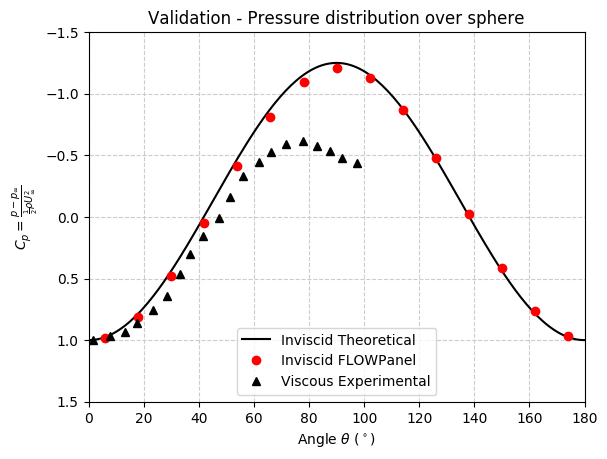

In [9]:
import CSV
import DataFrames: DataFrame
import PyPlot
plt = PyPlot

# Invicid potential flow
theo_theta = range(0, stop=pi, length=180)
theo_Cp = 1 .- 9 / 4 * (sin.(theo_theta)) .^ 2
plt.plot(theo_theta * 180 / pi, theo_Cp, "-k", label="Inviscid Theoretical")

# MyPanel
dim_plot = 2
ncells = body.grid._ndivscells[dim_plot]
dtheta = (P_max[dim_plot]-P_min[dim_plot])/ncells
pnl_theta = [i * dtheta - dtheta / 2 for i in 1:ncells]

if dim_plot==1
    pnl_U = [gt.get_fieldval(body.grid, "V", [i, Int(floor(body.grid._ndivscells[2] / 2))]) for i in 1:ncells]
else
    pnl_U = [gt.get_fieldval(body.grid, "V", [Int(floor(body.grid._ndivscells[1] / 2)), i]) for i in 1:ncells]
end
                
pnl_Cp = [1 - (norm(U) / magVinf)^2 for U in pnl_U]
plt.plot(pnl_theta * 180 / pi, pnl_Cp, "or", label="Inviscid FLOWPanel")



# Experimental
data = CSV.read("data/sphere_exp_CP.csv", DataFrame, header=["theta", "Cp"])
exp_theta = data[!, 1]
exp_Cp = data[!, 2]
plt.plot(exp_theta, exp_Cp, "^k", label="Viscous Experimental")

plt.title("Validation - Pressure distribution over sphere")
plt.ylim([1.5, -1.5])
plt.xlim([0, 180])
plt.xlabel(plt.L"Angle $\theta$ ($^\circ$)")
plt.ylabel(plt.L"$C_p=\frac{p-p_\infty}{\frac{1}{2}\rho U_\infty^2}$")
plt.grid(true, color="0.8", linestyle="--")
plt.legend(loc="best");

# WORK IN PROGRESS

## Rigid-Wake Lifting Body Solver

Note to self: See notebooks [`20180818`](https://nbviewer.jupyter.org/url/edoalvar2.groups.et.byu.net/LabNotebook/201808/20180818.ipynb) and [`20190522`](https://nbviewer.jupyter.org/url/edoalvar2.groups.et.byu.net/LabNotebook/201905/20190522.ipynb).

### Kutta Condition

The Kutta condition is formulated such that the flow will leave the trailing edge smoothly. This is achieved by cancelling the circulation of the vortex line along the trailing edge with the circulation of the wake across that line as explained in Katz and Plotkin's *Aerodynamics for Engineers*, Sec. 9.3.a. In that approach, the tangential velocity at the trailing edge is continuous. The condition is imposed as

\begin{align}
    \Gamma_w = \Gamma_U - \Gamma_L
\end{align}

<img src="img/IMG_3978.JPG" alt="Pic here" style="width: 500px;"/>

In order to impose the Kutta condition, the trailing edge must be indicated by the user following the nomenclature shown below.

For a wing (or any arbitrary structured surface mesh), the trailing edge is indicated by a collection of $m$ pairs of cells $\text{TE} = \{\text{pair}_1, ~\text{pair}_2, ~\dots , ~\text{pair}_m\}= \{(\text{cell}_{1,1}, \text{cell}_{1,2}), ~(\text{cell}_{2,1}, \text{cell}_{2,2}), ~\dots , ~(\text{cell}_{m,1}, \text{cell}_{m,2})\}$, where $\text{cell}_{i,1}$ denotes the upper cell and $\text{cell}_{i,2}$ the lower cell of the $i$-th pair. **Unless specified by a particular solver, $\text{pair}_i$ is not expected to be contiguous to $\text{pair}_{i+1}$.** A cell is either a set of indices or an individual index that indicates the cell to be retrieved by the function `GeometricTools.get_cell(grid, cell)`.

$m$ vortex rings are shed off the trailing edge at every time step as shown below (where the superscript indicates the time step when the ring was shed, meanwhile the subscript indicates the associated trailing edge vortex ring pair). The strength of the $i$-th vortex ring is $\Gamma_i = \Gamma_{i,1} - \Gamma_{i,2}$, with $\Gamma_{i,j}$ the strength of the ring located at $\text{cell}_{i,j}$.

<img src="img/TE02.png" alt="Pic here" style="width: 700px;"/>

**IMPORTANT:** The section of the ring that goes along the trailing edge is assumed to be in between points $\mathbf{p}_n$ and $\mathbf{p}_{n-1}$ of the either a upper or lower cell of $n$ nodes. Reconstructing the trailing edge from left (y-) to right (y+) is done as $\mathbf{p}_n - \mathbf{p}_{n-1}$ for a upper cell, and $\mathbf{p}_{n-1} - \mathbf{p}_{n}$ for a lower cell.

### Semi-Infinite Vortex

The velocity that a semi-infinite vortex induces at a point $\bf x$ aligned with the starting point $\mathbf{p}_2$ (*i.e.,* it lays in the same plane of normal $\hat{D}$ containing $\mathbf{p}_2$) of the vortex is calculated as

\begin{align}
    \mathbf{u}_{\infty/2}\left( \mathbf{x} \right) = \frac{\Gamma}{4 \pi h} \hat{n}
,\end{align}

with $\Gamma$ the vortex strength, $h = \Vert \mathbf{x} - \mathbf{p}_2 \Vert$ the normal distance to the vortex line, and $\hat{n} = \hat{D}\times\hat{h}$ is the vector normal to the plane defined by $\hat{D}$ and $\hat{h}$, where $\hat{D}$ is the direction to infinite and $\hat{h}$ is the direction $\hat{h} = \frac{\mathbf{x}-\mathbf{p}_2}{\Vert \mathbf{x}-\mathbf{p}_2 \Vert}$. Note that in this definition, **a positive $\Gamma$ denotes the vortex going out from $\mathbf{p}_2$ to infinite**.

If $\mathbf{x}$ is not aligned with ("in the same plane than") the start of the semi-infinite vortex, $\mathbf{p}_2$ is found by projecting $\mathbf{x}$ into the line vortex as

\begin{align}
    \mathbf{p}_2 =  \mathbf{p}_1 + \left[  \hat{D}  \cdot \left( \mathbf{x} - \mathbf{p}_1 \right) \right]  \hat{D}
,\end{align}

then the semi-infinite vortex is split up into two section: one bound vortex between $\mathbf{p}_1$ and $\mathbf{p}_2$, and a semi-infinite section coplanar with $\mathbf{x}$ starting from $\mathbf{p}_2$ as shown below.

<img src="img/semiinfinite00.png" alt="Pic here" style="width: 350px;"/>

Thus, the velocity is calculated as 

\begin{align}
    \mathbf{u}_\ell\left( \mathbf{x} \right) & = 
        \mathbf{u}_{\mathbf{p}_1\mathbf{p}_2}\left( \mathbf{x} \right) +
            \mathbf{u}_{\infty/2}\left( \mathbf{x} \right)
    \\
        & = -\frac{\Gamma_\ell}{4\pi} 
                \frac{{\bf r}_1 \times {\bf r}_2}{ \Vert {\bf r}_1 \times {\bf r}_2 \Vert^2}
                {\bf r}_{2,1} \cdot \left(
                    \frac{{\bf r}_1}{r_1} - \frac{{\bf r}_2}{r_2}
                \right) + \frac{\Gamma_\ell}{4 \pi h} \hat{n}
    \\
        & = \frac{\Gamma_\ell}{4\pi} \left[
                \frac{1}{h} \hat{n} -
                    \frac{{\bf r}_1 \times {\bf r}_2}{ \Vert {\bf r}_1 \times {\bf r}_2 \Vert^2}
                    {\bf r}_{2,1} \cdot \left(
                        \frac{{\bf r}_1}{r_1} - \frac{{\bf r}_2}{r_2}
                    \right)
            \right]
    \\
        & = \Gamma_\ell \mathbf{g}\left( \mathbf{x} \right)
\end{align}

**OBSERVATIONS**
* Both bound vortex and semi-infinite sections are singular as $\mathbf{x}$ becomes collinear with the vortex. The bound-vortex is calculated exactly as the sections of the vortex ring explained before, meanwhile the singularity of the semi-infinite vortex is avoided by defining a threshold where anything closer than that experiences no induced velocity.

#### Verification

**Vortex Aligned With $+z$**

Here is a semi-infinite vortex starting at z=0 and going to $+z$. Here we see the induced velocity increasing towards $+z$ and decaying towards $-z$.

<img src="img/versemiinf01.png" alt="Pic here" style="width: 900px;"/>

Checking that the flow rotates in the right direction:

<img src="img/versemiinf00.png" alt="Pic here" style="width: 900px;"/>

### Rigid Wake

<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing02_w.gif" alt="Vid here" style="width: 900px;"/>

Assuming a rigid steady wake, the vortex rings in the wake simply become semi-infinite vortices since all sections parallel to the trailing edge cancel with the corresponding section in contiguous rings, extending to infinte.

Following the nomenclature explained in the *Kutta Condition* section, and requiring the declaration of the trailing edge such that $\text{pair}_i$ is contiguous to $\text{pair}_{i+1}$, the trailing edge is composed by $m$ pair of cells and $m+1$ semi-infinite vortices as shown below. The strength of the $i$-th semi-infinite vortex is calculated as

\begin{equation}
    \Gamma_\ell^{\left(i\right)} = \begin{cases} 
                    - \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right)
                        & \text{if } i = 1
                    \\
                    \left( \Gamma_{\text{cell}_{i-1,1}} - \Gamma_{\text{cell}_{i-1,2}} \right)
                        & \text{if } i = m+1
                    \\
                    \left( \Gamma_{\text{cell}_{i-1,1}} - \Gamma_{\text{cell}_{i-1,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right)
                        & \sim
                \end{cases}
\end{equation}

<img src="img/TE00.png" alt="Pic here" style="width: 500px;"/>

Thus, the velocity induced by the wake $\mathbf{u}_w$ at an arbitrary point $\mathbf{x}$ is calculated as

\begin{align}
        \mathbf{u}_\text{w}\left( \mathbf{x} \right) 
        & = \sum\limits_{i=1}^{m+1} \mathbf{u}_\ell^{\left( i \right)} \left( \mathbf{x} \right)
    \\
        & = \sum\limits_{i=1}^{m+1} \Gamma_\ell^{\left(i\right)} \mathbf{g}_i \left( \mathbf{x} \right)
    \\
        & = - \left( \Gamma_{\text{cell}_{1,1}} - \Gamma_{\text{cell}_{1,2}} \right)
                \mathbf{g}_1 \left( \mathbf{x} \right) + 
                \sum\limits_{i=2}^{m} \Gamma_\ell^{\left(i\right)} \mathbf{g}_i \left( \mathbf{x} \right) +
                \left( \Gamma_{\text{cell}_{m,1}} - \Gamma_{\text{cell}_{m,2}} \right)
                    \mathbf{g}_{m+1} \left( \mathbf{x} \right)
    \\
       & = - \left( \Gamma_{\text{cell}_{1,1}} - \Gamma_{\text{cell}_{1,2}} \right)
                \mathbf{g}_1 \left( \mathbf{x} \right) 
    \\ & \quad +
                 \left[ \left( \Gamma_{\text{cell}_{1,1}} - \Gamma_{\text{cell}_{1,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{2,1}} - \Gamma_{\text{cell}_{2,2}} \right) \right]
                    \mathbf{g}_{2} \left( \mathbf{x} \right)
    \\ & \quad +
                \left[ \left( \Gamma_{\text{cell}_{2,1}} - \Gamma_{\text{cell}_{2,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{3,1}} - \Gamma_{\text{cell}_{3,2}} \right) \right]
                    \mathbf{g}_{3} \left( \mathbf{x} \right) 
    \\ & \quad + 
                \ldots 
    \\ & \quad +
                \left[ \left( \Gamma_{\text{cell}_{i-1,1}} - \Gamma_{\text{cell}_{i-1,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right) \right]
                    \mathbf{g}_{i} \left( \mathbf{x} \right) 
    \\ & \quad +
                \ldots
    \\ & \quad +
                \left[ \left( \Gamma_{\text{cell}_{m-2,1}} - \Gamma_{\text{cell}_{m-2,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{m-1,1}} - \Gamma_{\text{cell}_{m-1,2}} \right) \right]
                    \mathbf{g}_{m-1} \left( \mathbf{x} \right)
    \\ & \quad +
                 \left[ \left( \Gamma_{\text{cell}_{m-1,1}} - \Gamma_{\text{cell}_{m-1,2}} \right) - 
                    \left( \Gamma_{\text{cell}_{m,1}} - \Gamma_{\text{cell}_{m,2}} \right) \right]
                    \mathbf{g}_{m} \left( \mathbf{x} \right) 
    \\ & \quad +
                \left( \Gamma_{\text{cell}_{m,1}} - \Gamma_{\text{cell}_{m,2}} \right)
                    \mathbf{g}_{m+1} \left( \mathbf{x} \right)
    \\
        & = \left( \Gamma_{\text{cell}_{1,1}} - \Gamma_{\text{cell}_{1,2}} \right)
                \left( \mathbf{g}_2 \left( \mathbf{x} \right) - \mathbf{g}_1 \left( \mathbf{x} \right) \right)
    \\ & \quad +
                 \left( \Gamma_{\text{cell}_{2,1}} - \Gamma_{\text{cell}_{2,2}} \right)
                \left( \mathbf{g}_3 \left( \mathbf{x} \right) - \mathbf{g}_2 \left( \mathbf{x} \right) \right)
    \\ & \quad +
                \ldots 
    \\ & \quad +
                 \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right)
                \left( \mathbf{g}_{i+1} \left( \mathbf{x} \right) - \mathbf{g}_i \left( \mathbf{x} \right) \right)
    \\ & \quad +
                \ldots
    \\ & \quad +
                 \left( \Gamma_{\text{cell}_{m-1,1}} - \Gamma_{\text{cell}_{m-1,2}} \right)
                \left( \mathbf{g}_{m} \left( \mathbf{x} \right) - \mathbf{g}_{m-1} \left( \mathbf{x} \right) \right)
    \\ & \quad +
                 \left( \Gamma_{\text{cell}_{m,1}} - \Gamma_{\text{cell}_{m,2}} \right)
                \left( \mathbf{g}_{m+1} \left( \mathbf{x} \right) - \mathbf{g}_m \left( \mathbf{x} \right) \right)
.\end{align}

Therefore

\begin{align} \boxed{
    \mathbf{u}_\text{w}\left( \mathbf{x} \right)  = \sum\limits_{i=1}^m
                \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right)
                \left( \mathbf{g}_{i+1} \left( \mathbf{x} \right) - \mathbf{g}_i \left( \mathbf{x} \right) \right)
    }
,\end{align}

or 

\begin{align} 
        \mathbf{u}_\text{w}\left( \mathbf{x} \right)  
        & = \sum\limits_{i=1}^m
                    \Gamma_{\text{cell}_{i,1}}
                    \left( \mathbf{g}_{i+1} 
                    \left( \mathbf{x} \right) - \mathbf{g}_i \left( \mathbf{x} \right) \right) - 
                    \sum\limits_{i=1}^m
                    \Gamma_{\text{cell}_{i,2}}
                    \left( \mathbf{g}_{i+1} \left( \mathbf{x} \right) - 
                    \mathbf{g}_i \left( \mathbf{x} \right) \right)
.\end{align}

### Problem Formulation

The velocity induced by the body paneled with $n$ vortex ring is calculated as 

\begin{align}
        \mathbf{u}_\text{b}\left( \mathbf{x} \right) 
        & = \sum\limits_{i=1}^n 
            \mathbf{u}_\text{ring}^{\left( i \right)} \left( \mathbf{x} \right)
    \\
        & = \sum\limits_{i=1}^n 
            \Gamma_i \mathbf{g}_\text{ring}^{\left( i \right)} \left( \mathbf{x} \right)
.\end{align}

The Kutta condition is imposed by cancelling the circulation of the sections of vortex rings along the trailing edge by adding a bound vortex of the same magnitude in between the starting points of every semi-infinite vortex as

\begin{align}
        \mathbf{u}_\text{kt} \left( \mathbf{x} \right)
        & = \sum\limits_{i=1}^m
                \left( \Gamma_{\text{cell}_{i,1}} - \Gamma_{\text{cell}_{i,2}} \right)
                \mathbf{g}_{1,2}^{\left( i \right)} \left( \mathbf{x} \right)
    \\
        & = \sum\limits_{i=1}^m
                 \Gamma_{\text{cell}_{i,1}}
                 \mathbf{g}_{\mathbf{p}_{n-1},\mathbf{p}_n}^{\left( U_i \right)} \left( \mathbf{x} \right) -
             \sum\limits_{i=1}^m
                 \Gamma_{\text{cell}_{i,2}}
                 \mathbf{g}_{\mathbf{p}_{n},\mathbf{p}_{n-1}}^{\left( L_i \right)} \left( \mathbf{x} \right)
,\end{align}

with $\mathbf{g}_{\mathbf{p}_{n},\mathbf{p}_{n-1}}^{\left( L_i \right)}$ the geometric component of the bound vortex between points $\mathbf{p}_{n}$ and $\mathbf{p}_{n-1}$ of the $i$-th lower cell along the trailing edge, and $\mathbf{g}_{\mathbf{p}_{n-1},\mathbf{p}_n}^{\left( U_i \right)}$  the bound vortex between $\mathbf{p}_{n-1}$ and $\mathbf{p}_{n}$ of the $i$-th upper cell.

The total velocity induced at an arbitrary point $\mathbf{x}$ is calculated as

\begin{align}
        \mathbf{u}_\text{ind}\left( \mathbf{x} \right) 
        & = \mathbf{u}_\text{b}\left( \mathbf{x} \right) + 
        \mathbf{u}_\text{w}\left( \mathbf{x} \right) +
        \mathbf{u}_\text{kt} \left( \mathbf{x} \right)
    \\
        & = \sum\limits_{i=1}^n 
            \Gamma_i \mathbf{g}_\text{ring}^{\left( i \right)} \left( \mathbf{x} \right) 
     \\
         & \quad + 
            \sum\limits_{j=1}^m
                    \Gamma_{\text{cell}_{j,1}}
                    \left( \mathbf{g}_{j+1} 
                    \left( \mathbf{x} \right) - \mathbf{g}_j \left( \mathbf{x} \right) \right) - 
                    \sum\limits_{j=1}^m
                    \Gamma_{\text{cell}_{j,2}}
                    \left( \mathbf{g}_{j+1} \left( \mathbf{x} \right) - 
                    \mathbf{g}_j \left( \mathbf{x} \right) \right) 
     \\
         & \quad + 
            \sum\limits_{j=1}^m
                 \Gamma_{\text{cell}_{j,1}}
                 \mathbf{g}_{\mathbf{p}_{n-1},\mathbf{p}_n}^{\left( U_j \right)} \left( \mathbf{x} \right) -
             \sum\limits_{j=1}^m
                 \Gamma_{\text{cell}_{j,2}}
                 \mathbf{g}_{\mathbf{p}_{n},\mathbf{p}_{n-1}}^{\left( L_j \right)} \left( \mathbf{x} \right)
    \\
        & = \sum\limits_{i=1}^n 
            \Gamma_i \mathbf{G}_i \left( \mathbf{x} \right)
,\end{align}

Where $\mathbf{G}_i$ is a function that discriminates whether the panel $i$ is in the trailing edge and adds the semi-infinite vortex component along with the geometry of the vortex ring and Kutta condition as follows

\begin{align}
        \mathbf{G}_i\left( \mathbf{x} \right) 
        & = 
        \mathbf{g}_\text{ring}^{\left( i \right)} \left( \mathbf{x} \right)
    \\
        & \quad +
        (i \in \mathbf{U} ?)\left( 
                    \mathbf{g}_{\text{map}\left( \mathbf{U} , i \right)+1} \left( \mathbf{x} \right) -
                    \mathbf{g}_{\text{map}\left( \mathbf{U} , i \right)} \left( \mathbf{x} \right) +
                    \mathbf{g}_{\mathbf{p}_{n-1},\mathbf{p}_n}^{
                        \left( \text{map}\left( \mathbf{U} , i \right) \right)
                    } \left( \mathbf{x} \right)
                \right) 
    \\
        & \quad -
        (i \in \mathbf{L} ?)\left( 
                    \mathbf{g}_{\text{map}\left( \mathbf{L} , i \right)+1} \left( \mathbf{x} \right) - 
                    \mathbf{g}_{\text{map}\left( \mathbf{L} , i \right)} \left( \mathbf{x} \right) + 
                    \mathbf{g}_{\mathbf{p}_{n},\mathbf{p}_{n-1}}^{
                        \left( \text{map}\left( \mathbf{L} , i \right) \right)
                    } \left( \mathbf{x} \right) 
                \right)
\end{align}

Scratch that, I just realized that I can avoid all that husle of cancelling the sections along the trailing edge by simply never calculating them. This is easily done by adding the flag `closed_ring=false` to the function `Vvortexring()`, which calculates the velocity along the sections in between all nodes of the ring without closing the ring in between the last and the first node. Thus, the induced velocity is calculated as


\begin{align}
        \mathbf{u}_\text{ind}\left( \mathbf{x} \right) 
        & = \mathbf{u}_\text{b}^*\left( \mathbf{x} \right) + 
        \mathbf{u}_\text{w}\left( \mathbf{x} \right) 
    \\
        & = \sum\limits_{i=1}^n 
            \Gamma_i \mathbf{g}_\text{ring}^{*\left( i \right)} \left( \mathbf{x} \right) + 
            \sum\limits_{j=1}^m
                    \Gamma_{\text{cell}_{j,1}}
                    \left( \mathbf{g}_{j+1} 
                    \left( \mathbf{x} \right) - \mathbf{g}_j \left( \mathbf{x} \right) \right) - 
                    \sum\limits_{j=1}^m
                    \Gamma_{\text{cell}_{j,2}}
                    \left( \mathbf{g}_{j+1} \left( \mathbf{x} \right) - 
                    \mathbf{g}_j \left( \mathbf{x} \right) \right) 
    \\
        & = \sum\limits_{i=1}^n 
            \Gamma_i \mathbf{G}_i \left( \mathbf{x} \right)
,\end{align}

with 
\begin{align}
        \mathbf{G}_i\left( \mathbf{x} \right) 
        & = 
        \mathbf{g}_\text{ring}^{*\left( i \right)} \left( \mathbf{x} \right)
    \\
        & \quad +
        (i \in \mathbf{U} ?)\left( 
                    \mathbf{g}_{\text{map}\left( \mathbf{U} , i \right)+1} \left( \mathbf{x} \right) -
                    \mathbf{g}_{\text{map}\left( \mathbf{U} , i \right)} \left( \mathbf{x} \right) 
                \right) 
    \\
        & \quad -
        (i \in \mathbf{L} ?)\left( 
                    \mathbf{g}_{\text{map}\left( \mathbf{L} , i \right)+1} \left( \mathbf{x} \right) - 
                    \mathbf{g}_{\text{map}\left( \mathbf{L} , i \right)} \left( \mathbf{x} \right) 
                \right)
,\end{align}

where $\mathbf{g}_\text{ring}^{*}$ is the vortex ring geometry function that discriminates whether the ring is in the trailing edge and leaves it open.

The no-flow-condition is then imposed at the $i$-th control point as

\begin{align}
        \left( \mathbf{u}_{\text{ind}}\left( \mathbf{x}_i \right) \right) \cdot \hat{n}_i 
        & = - \mathbf{u}_\infty\left( \mathbf{x}_i \right) \cdot \hat{n}_i
    \\ \Leftrightarrow
        \sum\limits_{j=1}^N 
        \Gamma_j \mathbf{G}_j \left( \mathbf{x}_i \right) \cdot \hat{n}_i
        & = - \mathbf{u}_\infty\left( \mathbf{x}_i \right) \cdot \hat{n}_i
    \\ \Leftrightarrow
        \begin{bmatrix}
            {\bf G}_1  \left( {\bf x}_i \right) \cdot \hat{n}_i 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_i \right) \cdot \hat{n}_i
        \end{bmatrix}
        \begin{bmatrix}
            \Gamma_1 \\ \vdots \\ \Gamma_N
        \end{bmatrix}
                & = - \mathbf{u}_\infty\left( \mathbf{x}_i \right) \cdot \hat{n}_i
\end{align}

In order to solve for the $N$ unkown gammas, we impose the condition in all $N$ control points, resulting in the following system of equations:

\begin{align}
        \begin{bmatrix}
            {\bf G}_1  \left( {\bf x}_1 \right) \cdot \hat{n}_1 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_1 \right) \cdot \hat{n}_1
        \\
                \vdots & \ddots &
        \\
            {\bf G}_1  \left( {\bf x}_N \right) \cdot \hat{n}_N 
                & \cdots & 
            {\bf G}_N  \left( {\bf x}_N \right) \cdot \hat{n}_N
        \end{bmatrix}
        \begin{bmatrix}
            \Gamma_1 \\ \vdots \\ \Gamma_N
        \end{bmatrix}
    & = - 
        \begin{bmatrix}
            \mathbf{u}_\infty\left( \mathbf{x}_1 \right) \cdot \hat{n}_i
        \\
            \vdots
        \\
            \mathbf{u}_\infty\left( \mathbf{x}_N \right) \cdot \hat{n}_i
        \end{bmatrix}
\end{align}

or 

\begin{align} \boxed{
        \mathbb{G}\boldsymbol\Gamma = -\boldsymbol\Lambda,
        \qquad \text{ with }
        \qquad (\mathbb{G})_{ij} = {\bf G}_j\left( {\bf x}_i \right) \cdot \hat{n}_i,
        \qquad (\boldsymbol\Gamma)_j = \Gamma_j,
        \qquad (\boldsymbol\Lambda)_i = \mathbf{u}_\infty\left( \mathbf{x}_i \right) \cdot \hat{n}_i
    }
\end{align}

**ASSUMPTIONS**
* In the declaration of the trailing edge, $\text{pair}_i$ is expected to be contiguous to $\text{pair}_{i+1}$. **CORRECTION:** I initially assumed so to develop the math, but turns out that there is no need for it in the implementation. **CORRECTION TO THE CORRECTION:** The solver won't need it, but the function for calculating the induced velocity will.
* The line along the trailing edge of every indicated panel is expected to be that in between the first and the second node, with the first node the starting point of the incoming semi-infinte vortex and the second node the outgoing one for the upper side, and flipped for the lower side.


**DON'T FORGET TO SUBSTRACT THE PORTION OF THE VORTEX RINGS AT THE TRAILING EDGE TO SATISFY THE KUTTA CONDITION! VERIFY IT**

### Validation: Bertin's Wing

Not quite there yet

<img src="img/bertins00.png" alt="Pic here" width="900px">

Generating body...
 12.953221 seconds (79.44 M allocations: 6.968 GiB, 7.29% gc time, 0.06% compilation time)
	Number of panels:	1440
Solving body...


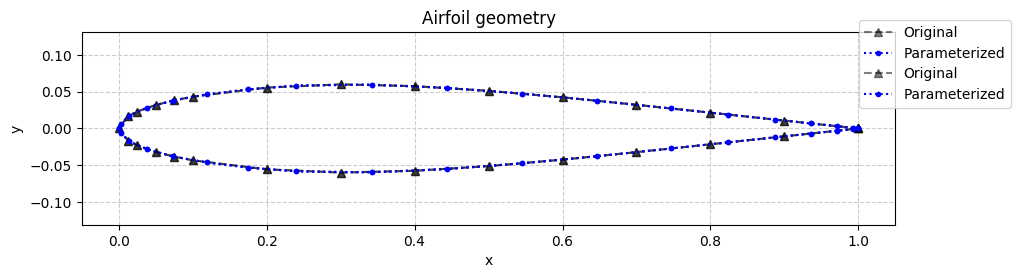

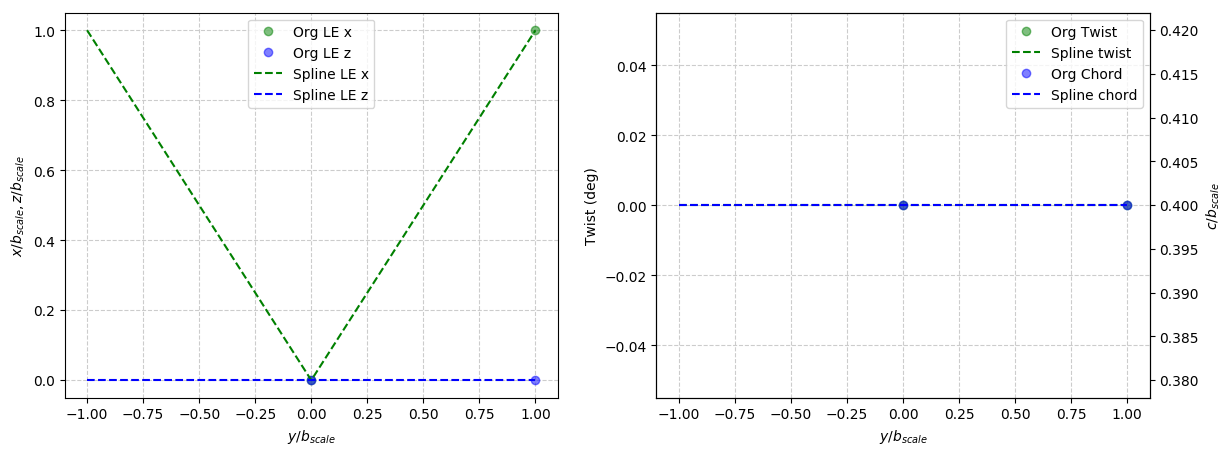

  3.120187 seconds (3.41 M allocations: 351.390 MiB, 1.40% gc time, 20.10% compilation time)
Done!


In [7]:
save_path     = "./bertinswing00/" # Save path

run_name      = "wing"
verbose       = true
v_lvl         = 0
paraview      = true

# ----------------- SIMULATION PARAMETERS ------------------------------------------
AOA           = 4.2                            # (deg) angle of attack
magVinf       = 30.0                           # (m/s) freestream velocity
Vinf          = magVinf*[cos(AOA*pi/180), 0, sin(AOA*pi/180)] # Freestream

# ----------------- GEOMETRY DESCRIPTION -------------------------------------------
b             = 98*0.0254                      # (m) span length
ar            = 5.0                            # Aspect ratio b/c_tip
tr            = 1.0                            # Taper ratio c_tip/c_root
twist_root    = 0                              # (deg) twist at root
twist_tip     = 0                              # (deg) twist at tip
lambda        = 45                             # (deg) sweep
gamma         = 0                              # (deg) dihedral
airfoil       = "rae101_report.csv"            # Airfoil contour file

span_NDIVS    = [(1.0, 20, 1.0, true)]


# ----------------- CALL SOLVER ----------------------------------------------------
# Generate body
if verbose; println("\t"^(v_lvl)*"Generating body..."); end;

@time wing = pnl.simplewing(b, ar, tr, twist_root, twist_tip, lambda, gamma;
                            bodytype=pnl.RigidWakeBody, 
                            airfoil_root=airfoil, airfoil_tip=airfoil,
                            airfoil_path=airfoil_path,
                            delim=",",
                            span_NDIVS=span_NDIVS)

if verbose; println("\t"^(v_lvl+1)*"Number of panels:\t$(wing.ncells)"); end;

# Calculate freestream at every control point, and direction
# of each semi-infinite TE vortex filament.
D             = [Vinf for i in 1:wing.nnodesTE]/norm(Vinf)
Vinfs         = [Vinf for i in 1:wing.ncells]
    
# Solve body
if verbose; println("\t"^(v_lvl)*"Solving body..."); end;
@time pnl.solve(wing, Vinfs, D)


if verbose; println("\t"^(v_lvl)*"Done!"); end;

In [5]:
# ----------------- POST-PROCESSING ------------------------------------------------

# Control points
CPs = [pnl.get_controlpoint(wing, i) for i in 1:wing.ncells]

# Freestream velocity at every CP
Vsurf = [Vinf for i in 1:wing.ncells]


if verbose; println("\t"^(v_lvl)*"Calculating body-induced velocity..."); end;
    
# Sorts trailing edge indices
_U = sort(wing.U)
_L = sort(wing.L)

cur_u = 1                 # Index of current upper trailing edge cell
cur_l = 1                 # Index of current lower trailing edge cell
    
# Iterate over each panel calculating body-induced velocity at every CP
for i in 1:wing.ncells 
    
    panel = pnl.gt.get_cell(wing.grid, i)
    # nodes = view( wing.grid.orggrid.nodes, :, vcat(panel[end], panel[1:end-1]) )
    # nodes = [wing.grid.orggrid.nodes[:, n] for n in vcat(panel[end], panel[1:end-1])]
    nodes = [view(wing.grid.orggrid.nodes, :, n) for n in vcat(panel[end], panel[1:end-1])]

    pnl.PanelSolver.Vvortexring(nodes, pnl.get_fieldval(wing, "Gamma", i), CPs,Vsurf;
                                # Checks for TE
                                closed_ring= !( (cur_u<=size(_U,1) && i==_U[cur_u]) ||
                                                (cur_l<=size(_L,1) && i==_L[cur_l]))
                                )

    if cur_u<=size(_U,1) && i==_U[cur_u]; cur_u+=1; end;
    if cur_l<=size(_L,1) && i==_L[cur_l]; cur_l+=1; end;
    
end

if verbose; println("\t"^(v_lvl)*"Calculating wake-induced velocity..."); end;

# Iterates over upper side of TE calculating semi-infinite wake induced velocity
@time for (j, u_j) in enumerate(wing.U) 

    # Upper in-going vortex
    pnl.PanelSolver.Vsemiinfinitevortex(
                          pnl.get_TE(wing, j+1; upper=true),# Starting point
                          D[j+1],                           # Direction
                          -pnl.get_fieldval(wing, "Gamma", u_j), # Unitary strength
                          CPs,                              # Targets
                          Vsurf                             # Velocity of j-th horseshoe on every CP
                        )

    # Upper out-going vortex
    pnl.PanelSolver.Vsemiinfinitevortex(
                          pnl.get_TE(wing, j; upper=true),  # Starting point
                          D[j],                             # Direction
                          pnl.get_fieldval(wing, "Gamma", u_j),     # Unitary strength
                          CPs,                              # Targets
                          Vsurf                             # Velocity of j-th horseshoe on every CP
                        )
end

@time for (j, l_j) in enumerate(wing.L) # Iterates over lower side of TE

    # Incoming vortex
    pnl.PanelSolver.Vsemiinfinitevortex(
                          pnl.get_TE(wing, j; upper=false), # Starting point
                          D[j],                             # Direction
                          -pnl.get_fieldval(wing, "Gamma", l_j),# Unitary strength
                          CPs,                          # Targets
                          Vsurf                             # Velocity of j-th horseshoe on every CP
                        )

    # Outgoing vortex
    pnl.PanelSolver.Vsemiinfinitevortex(
                          pnl.get_TE(wing, j+1; upper=false),# Starting point
                          D[j+1],                           # Direction
                          pnl.get_fieldval(wing, "Gamma", l_j), # Unitary strength
                          CPs,                              # Targets
                          Vsurf                             # Velocity of j-th horseshoe on every CP
                        )
end

if verbose; println("\t"^(v_lvl)*"Done!"); end;

point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]
pnl.gt.add_field(wing.grid, "V", "vector", Vsurf, "cell")

# ----------------- VISUALIZATION --------------------------------------------------
# Save vtk and call paraview
if verbose; println("\t"^(v_lvl)*"Saving VTKs..."); end;
str = save_path*"/"
@time str *= pnl.save(wing, run_name; path=save_path, 
                        out_nodeindex=true, 
                        out_cellindex=true, out_cellindexdim=[1,2], 
                        out_controlpoints=true,
                        out_wake=true, _len=b/2,)

if paraview
    if verbose; println("\t"^(v_lvl)*"Calling Paraview..."); end;
    run(`paraview --data=$str`)
end

str

Calculating body-induced velocity...
Calculating wake-induced velocity...
  0.393857 seconds (1.64 M allocations: 157.684 MiB, 6.74% gc time, 61.89% compilation time)
  0.143281 seconds (1.49 M allocations: 148.943 MiB, 10.43% gc time)
Done!
Saving VTKs...
 14.126898 seconds (77.24 M allocations: 7.678 GiB, 7.31% gc time, 41.17% compilation time)
Calling Paraview...


"./bertinswing00//wing_cp.vtk;wing_wake.vtk;wing.vtk;"

## Non-Lifting Vortex-Ring Solver

A non-lifting vortex-ring solver has been implemented but has not been verified nor validated yet. Here is what we currently get when we run the sphere validation with the vortex-ring solver:

In [3]:
using LinearAlgebra

save_path = "./"
file_name = "sphere04"

# Parameters
nu = 1.443e-5                    # (m^2/s) kinematic viscosity
Re = 8800                        # Reynolds number V*d/nu
# R = 6.35e-3/2                    # (m) radius of sphere
# magVinf = 20                     # (m/s) freestream velocity   
R = 1
magVinf = Re*nu/(2*R)

P_min = [0.15, 0, 0]             # Lower bounds of (theta, phi, dummy)
P_max = [pi-P_min[1], 2*pi, 0]   # Upper bounds of (theta, phi, dummy)
NDIVS = 1*[15, 30, 0]            # Number of divisions (cells) of (theta, phi, dummy)
loop_dim = 2                     # Coordinate to loop (1==theta)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Transforms the grid into a spherical cartesian space
my_transform(X) = pnl.gt.spherical3D(vcat(R, X[1:2]))
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)

# Creates non lifting body
# body = pnl.NonLiftingBody(triang_grid)
# body = pnl.NonLiftingBodyDoublet(triang_grid)
body = pnl.NonLiftingBodyVRing(triang_grid)

# Adds normal vector field

pnl.gt.add_field(body.grid, "normal", "vector",
                    [pnl.gt.get_normal(body.grid, i) for i in 1:body.ncells], "cell")

pnl.gt.add_field(body.grid, "cellindex", "scalar",
                    [i for i in 1:body.ncells], "cell")
pnl.gt.add_field(body.grid, "nodeindex", "scalar",
                    [i for i in 1:body.nnodes], "node")

# Freestream at every control point
Vinf = magVinf*[1.0,0,0]
Vinfs = [Vinf for i in 1:body.ncells]
pnl.solve(body, Vinfs)

# Adds surface velocity field
CPs = [pnl.get_controlpoint(body, i) for i in 1:body.ncells]
Vsurf = [Vinf for i in 1:size(CPs,1)]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
#     pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), CPs, Vsurf)
#     pnl.PanelSolver.Vconstant_doublet(pnodes, pnl.get_fieldval(body, "mu", i), CPs, Vsurf)
    pnl.PanelSolver.Vvortexring(pnodes, pnl.get_fieldval(body, "Gamma", i), CPs, Vsurf)
end
point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]
pnl.gt.add_field(body.grid, "V", "vector", Vsurf, "cell")

# Creates a fluid domain grid
fdom = gt.Grid(-3*R*ones(3), 3*R*ones(3), 2*[10,10,10])
targets = [gt.get_node(fdom, i) for i in 1:fdom.nnodes]
V = [Vinf for i in 1:fdom.nnodes]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
#     pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), targets, V)
#     pnl.PanelSolver.Vconstant_doublet(pnodes, pnl.get_fieldval(body, "mu", i), targets, V)
    pnl.PanelSolver.Vvortexring(pnodes, pnl.get_fieldval(body, "Gamma", i), targets, V)
end

gt.add_field(fdom, "V", "vector", V, "node")

# Saves vtk and calls paraview
pnl.save(body, file_name; path=save_path)
gt.save(fdom, file_name*"_fdom"; path=save_path)
gt.generateVTK(file_name*"_CPs", CPs; point_data=point_data, path=save_path)
strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_fdom.vtk;$(file_name)_CPs.vtk"
run(`paraview --data=$strn`)
nothing

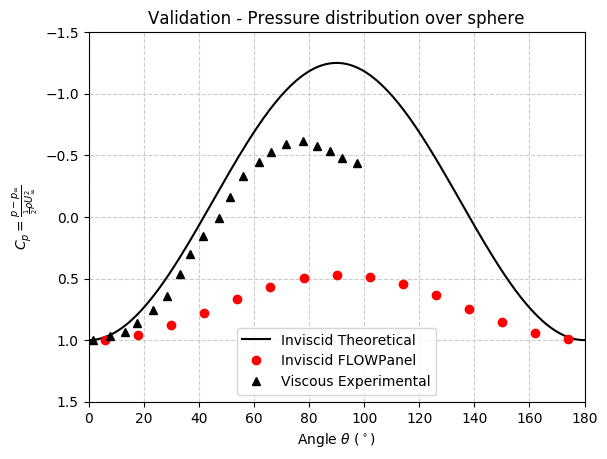

In [4]:
import CSV
import DataFrames: DataFrame
import PyPlot
plt = PyPlot

# Invicid potential flow
theo_theta = range(0, stop=pi, length=180)
theo_Cp = 1 .- 9 / 4 * (sin.(theo_theta)) .^ 2
plt.plot(theo_theta * 180 / pi, theo_Cp, "-k", label="Inviscid Theoretical")

# MyPanel
dim_plot = 2
ncells = body.grid._ndivscells[dim_plot]
dtheta = (P_max[dim_plot]-P_min[dim_plot])/ncells
pnl_theta = [i * dtheta - dtheta / 2 for i in 1:ncells]

if dim_plot==1
    pnl_U = [gt.get_fieldval(body.grid, "V", [i, Int(floor(body.grid._ndivscells[2] / 2))]) for i in 1:ncells]
else
    pnl_U = [gt.get_fieldval(body.grid, "V", [Int(floor(body.grid._ndivscells[1] / 2)), i]) for i in 1:ncells]
end
                
pnl_Cp = [1 - (norm(U) / magVinf)^2 for U in pnl_U]
plt.plot(pnl_theta * 180 / pi, pnl_Cp, "or", label="Inviscid FLOWPanel")



# Experimental
data = CSV.read("data/sphere_exp_CP.csv", DataFrame, header=["theta", "Cp"])
exp_theta = data[!, 1]
exp_Cp = data[!, 2]
plt.plot(exp_theta, exp_Cp, "^k", label="Viscous Experimental")

plt.title("Validation - Pressure distribution over sphere")
plt.ylim([1.5, -1.5])
plt.xlim([0, 180])
plt.xlabel(plt.L"Angle $\theta$ ($^\circ$)")
plt.ylabel(plt.L"$C_p=\frac{p-p_\infty}{\frac{1}{2}\rho U_\infty^2}$")
plt.grid(true, color="0.8", linestyle="--")
plt.legend(loc="best");

## Non-Lifting Doublet Solver

A non-lifting doublet solver has been implemented but has not been verified nor validated yet. Here is what we currently get when we run the sphere validation with the doublet solver:

In [3]:
using LinearAlgebra

save_path = "./"
file_name = "sphere03"

# Parameters
nu = 1.443e-5                    # (m^2/s) kinematic viscosity
Re = 8800                        # Reynolds number V*d/nu
# R = 6.35e-3/2                    # (m) radius of sphere
# magVinf = 20                     # (m/s) freestream velocity   
R = 1
magVinf = Re*nu/(2*R)

P_min = [0.15, 0, 0]             # Lower bounds of (theta, phi, dummy)
P_max = [pi-P_min[1], 2*pi, 0]   # Upper bounds of (theta, phi, dummy)
NDIVS = 1*[15, 30, 0]            # Number of divisions (cells) of (theta, phi, dummy)
loop_dim = 2                     # Coordinate to loop (1==theta)

# Generates parametric (theta, phi) grid 
grid = pnl.gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Transforms the grid into a spherical cartesian space
my_transform(X) = pnl.gt.spherical3D(vcat(R, X[1:2]))
pnl.gt.transform!(grid, my_transform)

# Splits the quad cells into triangular cells
dimsplit = 1
triang_grid = pnl.gt.GridTriangleSurface(grid, dimsplit)

# Creates non lifting body
# body = pnl.NonLiftingBody(triang_grid)

body = pnl.NonLiftingBodyDoublet(triang_grid)

# Adds normal vector field

pnl.gt.add_field(body.grid, "normal", "vector",
                    [pnl.gt.get_normal(body.grid, i) for i in 1:body.ncells], "cell")

pnl.gt.add_field(body.grid, "cellindex", "scalar",
                    [i for i in 1:body.ncells], "cell")
pnl.gt.add_field(body.grid, "nodeindex", "scalar",
                    [i for i in 1:body.nnodes], "node")

# Freestream at every control point
Vinf = magVinf*[1.0,0,0]
Vinfs = [Vinf for i in 1:body.ncells]
pnl.solve(body, Vinfs)

# Adds surface velocity field
CPs = [pnl.get_controlpoint(body, i) for i in 1:body.ncells]
Vsurf = [Vinf for i in 1:size(CPs,1)]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
#     pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), CPs, Vsurf)
    pnl.PanelSolver.Vconstant_doublet(pnodes, pnl.get_fieldval(body, "mu", i), CPs, Vsurf)
end
point_data = [Dict("field_name"=>"V", "field_type"=>"vector", "field_data"=>Vsurf)]
pnl.gt.add_field(body.grid, "V", "vector", Vsurf, "cell")

# Creates a fluid domain grid
fdom = gt.Grid(-3*R*ones(3), 3*R*ones(3), 2*[10,10,10])
targets = [gt.get_node(fdom, i) for i in 1:fdom.nnodes]
V = [Vinf for i in 1:fdom.nnodes]
for i in 1:body.ncells
    pnodes = gt.get_cellnodes(body.grid, i)
#     pnl.PanelSolver.Vconstant_source(pnodes, pnl.get_fieldval(body, "sigma", i), targets, V)
    pnl.PanelSolver.Vconstant_doublet(pnodes, pnl.get_fieldval(body, "mu", i), targets, V)
end

gt.add_field(fdom, "V", "vector", V, "node")

# Saves vtk and calls paraview
pnl.save(body, file_name; path=save_path)
gt.save(fdom, file_name*"_fdom"; path=save_path)
gt.generateVTK(file_name*"_CPs", CPs; point_data=point_data, path=save_path)
strn = "$(joinpath(save_path, file_name)).vtk;$(file_name)_fdom.vtk;$(file_name)_CPs.vtk"
run(`paraview --data=$strn`)
nothing

(   4.675s) [paraview        ]      vtkDataReader.cxx:1508  WARN| Error reading ascii data. Possible mismatch of datasize with declaration.
(   4.676s) [paraview        ]      vtkDataReader.cxx:838    ERR| vtkUnstructuredGridReader (0x62bc940): Unsupported cell attribute type: nan for file: /home/edoalvar/Dropbox/FLOWResearch/FLOWCodes/FLOWPanel/docs/sphere03.vtk
(   4.676s) [paraview        ]      vtkDataReader.cxx:1008   ERR| vtkUnstructuredGridReader (0x62bc940): Unsupported point attribute type: nan for file: /home/edoalvar/Dropbox/FLOWResearch/FLOWCodes/FLOWPanel/docs/sphere03.vtk
(   4.921s) [paraview        ]      vtkDataReader.cxx:1508  WARN| Error reading ascii data. Possible mismatch of datasize with declaration.
(   4.921s) [paraview        ]      vtkDataReader.cxx:1008   ERR| vtkUnstructuredGridReader (0x7e19560): Unsupported point attribute type: nan for file: /home/edoalvar/Dropbox/FLOWResearch/FLOWCodes/FLOWPanel/docs/sphere03_fdom.vtk
(   5.026s) [paraview        ]     

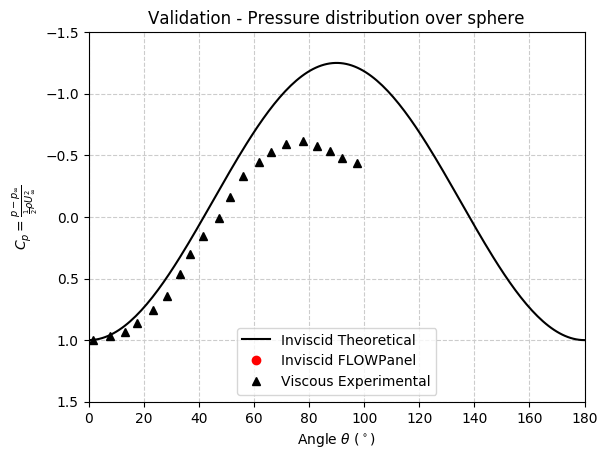

In [4]:
import CSV
import DataFrames: DataFrame
import PyPlot
plt = PyPlot

# Invicid potential flow
theo_theta = range(0, stop=pi, length=180)
theo_Cp = 1 .- 9 / 4 * (sin.(theo_theta)) .^ 2
plt.plot(theo_theta * 180 / pi, theo_Cp, "-k", label="Inviscid Theoretical")

# MyPanel
dim_plot = 2
ncells = body.grid._ndivscells[dim_plot]
dtheta = (P_max[dim_plot]-P_min[dim_plot])/ncells
pnl_theta = [i * dtheta - dtheta / 2 for i in 1:ncells]

if dim_plot==1
    pnl_U = [gt.get_fieldval(body.grid, "V", [i, Int(floor(body.grid._ndivscells[2] / 2))]) for i in 1:ncells]
else
    pnl_U = [gt.get_fieldval(body.grid, "V", [Int(floor(body.grid._ndivscells[1] / 2)), i]) for i in 1:ncells]
end
                
pnl_Cp = [1 - (norm(U) / magVinf)^2 for U in pnl_U]
plt.plot(pnl_theta * 180 / pi, pnl_Cp, "or", label="Inviscid FLOWPanel")



# Experimental
data = CSV.read("data/sphere_exp_CP.csv", DataFrame, header=["theta", "Cp"])
exp_theta = data[!, 1]
exp_Cp = data[!, 2]
plt.plot(exp_theta, exp_Cp, "^k", label="Viscous Experimental")

plt.title("Validation - Pressure distribution over sphere")
plt.ylim([1.5, -1.5])
plt.xlim([0, 180])
plt.xlabel(plt.L"Angle $\theta$ ($^\circ$)")
plt.ylabel(plt.L"$C_p=\frac{p-p_\infty}{\frac{1}{2}\rho U_\infty^2}$")
plt.grid(true, color="0.8", linestyle="--")
plt.legend(loc="best");